In this notebook, we use [Stack Overflow Annual Developer Survey](https://insights.stackoverflow.com/survey) data to do some exploratory analyses of data jobs (Data Scientist, Data Analyst, Data Engineer). Analyses include facts on salary, job satisfaction, change of the data jobs (2019 v.s. 2020). Machine learning modelling has been also used to predict job satisfaction.

A medium post for non-technical audience can be found here: https://lcxustc.medium.com/salary-satisfaction-trend-of-data-jobs-f47bdf72afa3.

# Content:

1. Exploratory analysis of data-related developers.
2. Analyses of Salary.
3. What are the changes of data jobs (2020 compared to 2019)?
    * numbers of data roles;
    * Salary;
    * Job satisfaction, etc.
3. How to predict job satisfaction for data jobs?
    * Date preparation;
    * modelling;
    * Model explainability.

### CRISP-DM: Job Satisfaction prediction

In particular, for the job satisfaction prediction, the procedure of CRISP-DM for data mining the procedure of CRISP-DM (cross-industry process for data mining) is detailed here.

#### - Business Problem
We are interested in understanding job satisfaction for data jobs, and try to identify some important factors. This
 may be useful, as example, for a Career Advice & Coach Company to better plan career development for their
  customers, such as job seekers to switch to the data field or data professionals to make the next step in their
   career path. 

#### - Data Understanding
The Stack Overflow Survey Data is a questionnaire designed for people with general developer background. It
 cover questions about personal background such as age, gender, education level, and job-related questions such as
  salary, work hours, job types, job satisfaction, etc. We focus on responders who have a data-related jobs and use the
   response to job satisfaction as the entry point to understand what contribute to job satisfaction. Exploratory
    data analysis has been applied to get some preliminary insight into job satisfaction. Then modelling technique is
     applied.
 
#### - Data Preparation
To prepare the raw survey data for modelling purpose, we need to first extract responses that are associated with data-related jobs. Standard data preparation procedure has been applied, mainly include:

* select the subset of data of interest and transform raw data properly;
* feature selection;
* missing data imputation;
* categorical data encoding.
 
There are 10,372 data instances and 38 features after data preparation (54 feature columns after one-hot encoding). Please refer to Section 5 for more details on missing data imputation and categorical data encoding.
 
#### - Modelling
There are five possible response to job satisfaction, so it is a multi-classification problem. Data has been split
into training and test set. An untuned Gaussian Naive Bayes has been tried as a baseline model. And then grid search with cross-validation technique is applied to tune XGBoost model. Average ROC-AUC score has been used as the main metric for hyperparameter tuning and model performance evaluation, while other metrics such as Log-Loss, Accuracy, average Precision (macro), average Recall (macro) and confusion matrix have been used together to give a comprehensive evaluation of the model performance. 

#### - Evaluation
A set of metrics have been used to evaluation the model performance. Although there exist the overfitting issue to
some extent, the model performance is considered acceptable and the model has a reasonable predictive power. We also applied some explainability technique (e..g, [SHAP](https://github.com/slundberg/shap)) to get more insight of the modelling result, such as key drivers (e.g., Salary, OnboardExperience, Age, YearsCode, CompanySize) and dependence relationship w.r.t. predicting job satisfaction.
   
#### - Deployment
This project doesn't cover the deployment part, but with the trained model, one can productionize it, such as
 integrating it into an App, and score new data. 

### import packages and configure

In [1]:
import os
import sys

In [2]:
import numpy as np
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import seaborn as sns

In [5]:
# add the 'code' folder into sys.path to use helper functions

sys.path.insert(1, '/Users/lcx/Documents/courses/udacity_DS/2-Intro_to_DS/StackOverflow_Survey/code')

In [6]:
from data_process import extract_data_related

In [7]:
# working directory
root_dir = '/Users/lcx/Documents/courses/udacity_DS/2-Intro_to_DS/StackOverflow_Survey'

## 1. Exploratory analysis of data-related developers

In [269]:
df_survey = pd.read_csv(os.path.join(root_dir, 'data/developer_survey_2020/survey_results_public.csv'))

In [270]:
df_survey.shape

(64461, 61)

In [271]:
# how many missing DevType

df_survey['DevType'].isnull().sum()

15091

In [13]:
from collections import defaultdict

In [14]:
# get the counts of different developer types

df_DevType = df_survey['DevType'].value_counts().to_frame().reset_index().rename(columns={'DevType':'count', 'index': 'DevType'})

In [15]:
# replace ',' by '_' so we can split the string of DevType into a list later

df_DevType['DevType_list'] = df_DevType['DevType'].str.replace(', ', '_').str.split(';')

df_DevType['DevType_list'] = df_DevType['DevType_list'].apply(lambda x: set(x))  # convert list to dictionary for efficiency

df_DevType

,DevType,count,DevType_list
0,"Developer, full-stack",4424,{Developer_full-stack}
1,"Developer, back-end",3086,{Developer_back-end}
2,"Developer, back-end;Developer, front-end;Devel...",2227,"{Developer_front-end, Developer_full-stack, De..."
3,"Developer, back-end;Developer, full-stack",1476,"{Developer_full-stack, Developer_back-end}"
4,"Developer, front-end",1401,{Developer_front-end}
...,...,...,...
8264,"Developer, back-end;Developer, front-end;Devel...",1,"{Engineer_site reliability, DevOps specialist,..."
8265,"Academic researcher;Developer, back-end;Develo...",1,"{Developer_front-end, Academic researcher, Sci..."
8266,Academic researcher;Data or business analyst;D...,1,{Data scientist or machine learning specialist...
8267,"Developer, full-stack;Developer, game or graph...",1,"{Developer_mobile, Developer_game or graphics,..."


### 1.1. filter rows to keep data-related roles only:
* Data scientist or machine learning specialist
* Data or business analyst
* Engineer, data
    

In [16]:
df_DevType['data_related'] = df_DevType['DevType'].\
    str.contains('data(?![a-z])', case=False, regex=True)

df_DevType_data = df_DevType[df_DevType['data_related']==True].copy()

df_DevType_data.shape

(3889, 4)

In [17]:
df_DevType_data.head(5)

,DevType,count,DevType_list,data_related
13,Data scientist or machine learning specialist,369,{Data scientist or machine learning specialist},True
18,Data or business analyst,285,{Data or business analyst},True
24,"Developer, back-end;Engineer, data",227,"{Engineer_data, Developer_back-end}",True
30,"Engineer, data",189,{Engineer_data},True
32,Data or business analyst;Data scientist or mac...,186,{Data scientist or machine learning specialist...,True


In [18]:
print(f"Percentage of data-related roles from survey: {sum(df_DevType_data['count']) / len(df_survey)*100: 5.2f}%")

Percentage of data-related roles from survey:  13.54%


In [19]:
sum(df_DevType_data['count'])

8726

### 1.2. count number of different roles (associated with data-related)

What is the job distribution for all responders who have a data-related roles,

In [20]:
data_role_count = defaultdict(int)

for idx, row in df_DevType_data.iterrows():
    for role in row['DevType_list']:
        data_role_count[role] = data_role_count[role] + row['count']

In [21]:
data_role_count

defaultdict(int,
            {'Data scientist or machine learning specialist': 3988,
             'Data or business analyst': 4024,
             'Engineer_data': 3738,
             'Developer_back-end': 4843,
             'Scientist': 1140,
             'Academic researcher': 1585,
             'Developer_full-stack': 3814,
             'Developer_embedded applications or devices': 1024,
             'Developer_mobile': 1339,
             'DevOps specialist': 1359,
             'Senior executive/VP': 446,
             'Engineer_site reliability': 631,
             'Engineering manager': 771,
             'Developer_game or graphics': 563,
             'Marketing or sales professional': 295,
             'Developer_desktop or enterprise applications': 2184,
             'Designer': 1344,
             'Developer_front-end': 2578,
             'System administrator': 1504,
             'Educator': 891,
             'Database administrator': 2220,
             'Product manager': 876,
     

Text(0.5, 1.0, 'data-related roles count')

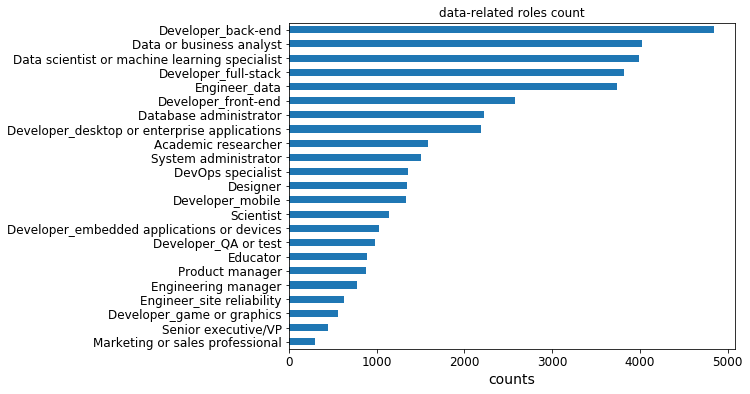

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.Series(data_role_count).sort_values().plot.barh(ax=ax)

ax.set_xlabel('counts')
ax.set_title('data-related roles count')

Text(0.5, 1.0, 'data roles (DS, DA, DE) count')

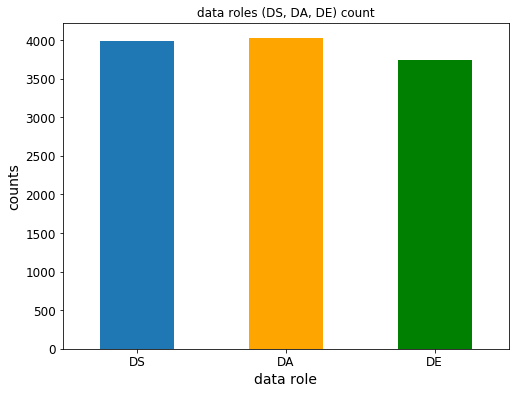

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

data_role_count_1 = {'DS': 3988, 'DA': 4024, 'DE': 3738}

pd.Series(data_role_count_1).plot(kind='bar', color=['C0', 'orange', 'green'], ax=ax, rot=0)

ax.set_xlabel('data role') 
# ax.set_xticklabels(ax.get_xticks(), rotation=90)
ax.set_ylabel('counts')
ax.set_title('data roles (DS, DA, DE) count')

### 1.3. count roles associated with each data role (Data Scientist, Data Analysis, Data Engineer)

For each type of data role, what is the distribution of job roles.

In [24]:
DS_multiple_roles = defaultdict(int)
DA_multiple_roles = defaultdict(int)
DE_multiple_roles = defaultdict(int)

DS_counts, DA_counts, DE_counts = 0, 0, 0
DS_only_counts, DA_only_counts, DE_only_counts = 0, 0, 0

for idx, row in df_DevType_data.iterrows(): 
            
    if 'Data scientist or machine learning specialist' in row['DevType_list']:
        DS_counts += row['count']
        if len(row['DevType_list']) == 1:
            DS_only_counts += row['count']
        for role in row['DevType_list']:
            DS_multiple_roles[role] = DS_multiple_roles[role] + row['count']
    
    if 'Data or business analyst' in row['DevType_list']:
        DA_counts += row['count']
        if len(row['DevType_list']) == 1:
            DA_only_counts += row['count']
        for role in row['DevType_list']:
            DA_multiple_roles[role] = DA_multiple_roles[role] + row['count']
            
    if 'Engineer_data' in row['DevType_list']:
        DE_counts += row['count']
        if len(row['DevType_list']) == 1:
            DE_only_counts += row['count']
        for role in row['DevType_list']:
            DE_multiple_roles[role] = DE_multiple_roles[role] + row['count']



In [25]:
index = ['DS', 'DA', 'DE']
total_count = [DS_counts, DA_counts, DE_counts]
only_count = [DS_only_counts, DA_only_counts, DE_only_counts]

df_counts = pd.DataFrame({'total_count': total_count, 'only_count': only_count}, index=index)

In [26]:
df_counts

,total_count,only_count
DS,3988,369
DA,4024,285
DE,3738,189


In [27]:
# how often the data role has the other developer duty
1 - df_counts['only_count'] / df_counts['total_count']

DS    0.907472
DA    0.929175
DE    0.949438
dtype: float64

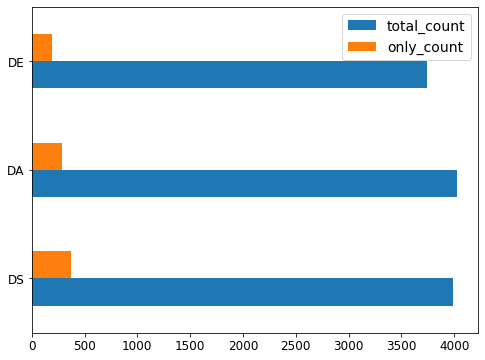

In [28]:
# for these three types of data jobs, how many responders only have one job duty and how many have multiple job duty

fig, ax = plt.subplots(figsize=(8, 6))

df_counts.plot.barh(ax=ax)

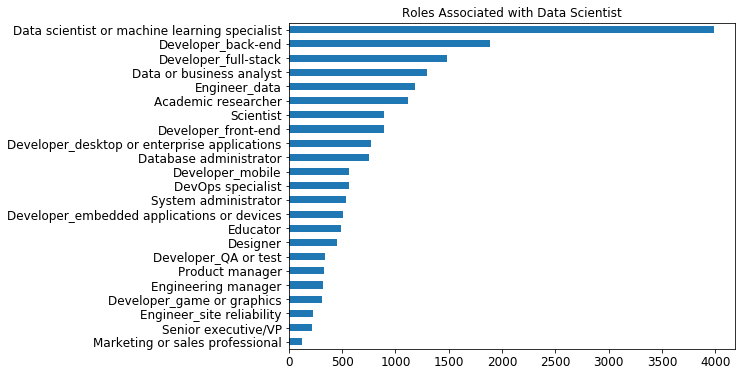

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(DS_multiple_roles).sort_values(ascending=True).plot.barh(ax=ax, 
                                                                   title='Roles Associated with Data Scientist')

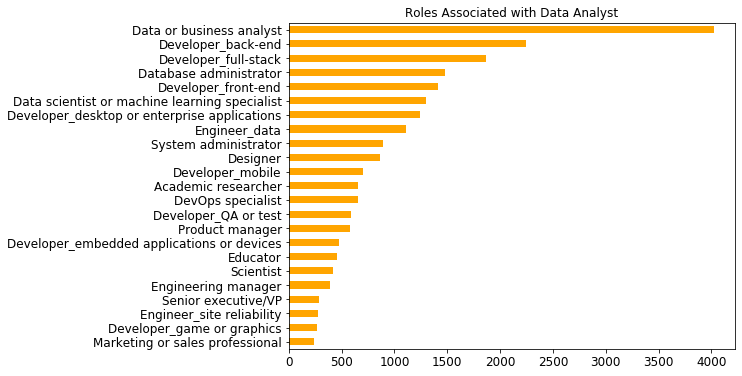

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(DA_multiple_roles).sort_values(ascending=True).plot.barh(ax=ax, 
                                                                   title='Roles Associated with Data Analyst', color='orange')

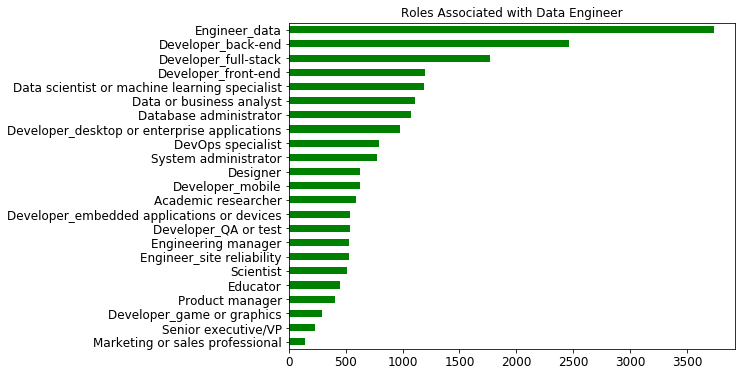

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(DE_multiple_roles).sort_values(ascending=True).plot.barh(ax=ax, 
                                                                   title='Roles Associated with Data Engineer', color='green')

## 2. Question: which data role earns the most?

### 2.1. convert raw data to dataframe with data-related roles

In [272]:
df_survey['data_related'] = df_survey['DevType'].\
    str.contains('data(?![a-z])', case=False, regex=True)

df_data = df_survey[df_survey['data_related']==True].copy()

In [273]:
df_data.shape

(8726, 62)

In [35]:
df_survey.shape

(64461, 62)

In [110]:
df_survey.shape

(64461, 62)

In [36]:
df_data['DevType']

21                    Developer, full-stack;Engineer, data
24       Developer, back-end;Developer, full-stack;DevO...
29       Data or business analyst;Database administrato...
35       Data or business analyst;Data scientist or mac...
43       Data or business analyst;Developer, back-end;P...
                               ...                        
64432    Data scientist or machine learning specialist;...
64437                             Data or business analyst
64446    Academic researcher;Data or business analyst;D...
64451        Data scientist or machine learning specialist
64453    Data or business analyst;Developer, mobile;Sen...
Name: DevType, Length: 8726, dtype: object

In [68]:
# focus on the actitely employed prarticipants only
valid_employed = ['Employed full-time', 'Employed part-time',
                  'Independent contractor, freelancer, or self-employed']
valid_employed_cond = df_survey['Employment'].isin(valid_employed)

sum(valid_employed_cond)

53159

In [111]:
data_related_cond = df_survey['data_related']==True

In [112]:
sum(data_related_cond)

8726

In [183]:
# focus on currently actively employed only
print(f"Total number of responders who are actively employed: {sum(valid_employed_cond)}\n"
      f"Percentage of responders who process a data-related role: "
      f"{sum(valid_employed_cond & data_related_cond) / sum(valid_employed_cond)*100: 5.2f}%")

Total number of responders who are actively employed: 53159
Percentage of responders who process a data-related role:  15.69%


**Note**:

we can see for responders who have a data professional, there could be more than one role. 

We convert one row to multiple rows if he/she has the roles as 'Data Scientist'/'Data Engineer'/'Data Analyst'.

In [274]:
df_data = extract_data_related(df_survey)

In [275]:
df_data.shape

(11186, 65)

### 2.2. exploratory anaylsis and visulization

#### 2.2.1. **salary v.s. data role**

In [ ]:
# number of DS/DA/DE
sns.catplot(x="data_role", kind='count', data=df_data)

In [191]:
df_data["data_role"].value_counts()

DA    3832
DS    3761
DE    3593
Name: data_role, dtype: int64

Text(0.5, 1, 'Numbers of Data Jobs')

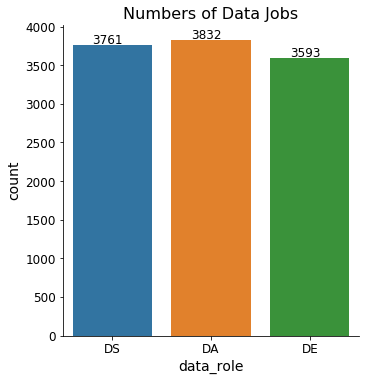

In [213]:
# number of DS/DA/DE
g = sns.catplot(x="data_role", kind='count', data=df_data)
# values = [3761, 3832, 3593]

for p, v in zip(g.axes.flat[0].patches, values):
    g.axes.flat[0].annotate(f"{v}", (p.get_x() * 1.0 + 0.2, p.get_height() * 1.005))

g.axes.flat[0].set_title("Numbers of Data Jobs", fontsize=16)

In [46]:
df_data['data_role'].value_counts()

DA    3832
DS    3761
DE    3593
Name: data_role, dtype: int64

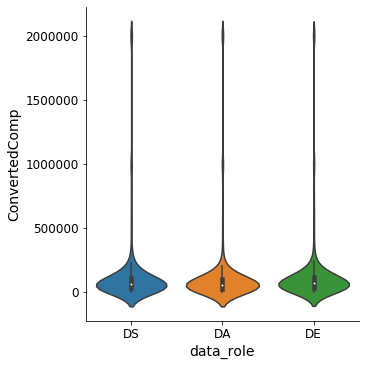

In [47]:
# distribution of salary for different data roles, violin plot
sns.catplot(x='data_role', y="ConvertedComp", kind="violin", data=df_data)

Text(0.5, 1, 'Salaries of Data Jobs')

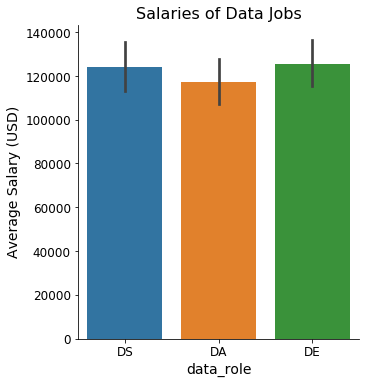

In [218]:
# distribution of salary for different data roles, bar plot

g = sns.catplot(x='data_role', y="ConvertedComp", kind='bar', data=df_data)

g.set(ylabel='Average Salary (USD)')
g.axes.flat[0].set_title("Salaries of Data Jobs", fontsize=16)

#### 2.2.2. **salary v.s. data role in different countries**

In [49]:
# get countries with top 9 counts
df_data['Country'].value_counts().iloc[:9]

United States     2757
India             1160
Germany            664
United Kingdom     653
Brazil             346
Canada             341
France             320
Australia          258
Netherlands        243
Name: Country, dtype: int64

Text(0.5, 0.98, 'Salaries of Data Jobs in Different Countries')

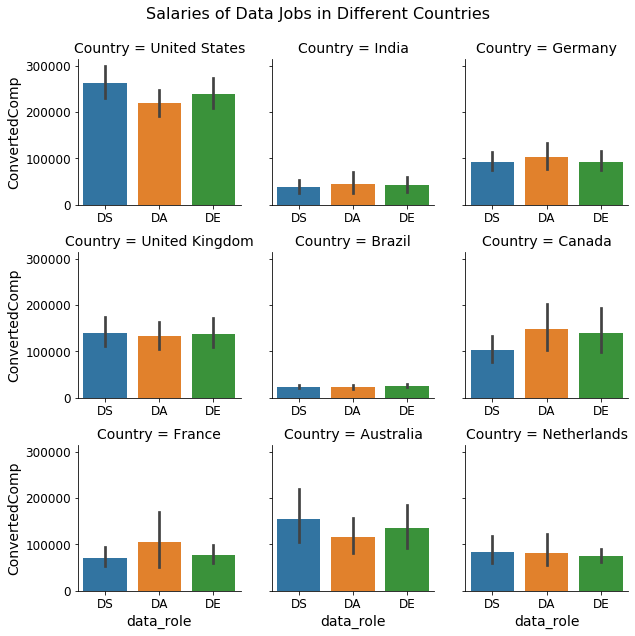

In [222]:
top_ten_countries = ['United States', 'India', 'Germany', 'United Kingdom', 'Brazil', 
                     'Canada', 'France', 'Australia', 'Netherlands']

g = sns.FacetGrid(df_data[df_data['Country'].isin(top_ten_countries)], 
                  col='Country', hue='data_role',
                  col_wrap=3, col_order=top_ten_countries, sharex=False)
g.map(sns.barplot, 'data_role', "ConvertedComp", order=["DS", "DA", "DE"])

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Salaries of Data Jobs in Different Countries')

#### 2.2.3. **salary vs. data role for different gender**

In [51]:
df_data['Gender'].value_counts()

Man                                                            8732
Woman                                                           716
Non-binary, genderqueer, or gender non-conforming                65
Man;Non-binary, genderqueer, or gender non-conforming            35
Woman;Non-binary, genderqueer, or gender non-conforming          26
Woman;Man;Non-binary, genderqueer, or gender non-conforming      20
Woman;Man                                                        18
Name: Gender, dtype: int64

In [52]:
df_data['Gender_1'] = df_data['Gender'].apply(
    lambda x: x if pd.isna(x) or x == 'Man' or x == 'Woman' else 'others')

In [223]:
df_data['Gender_1'].value_counts()

Man       8732
Woman      716
others     164
Name: Gender_1, dtype: int64

Text(0.5, 1, 'Gender Distribution in Data Jobs')

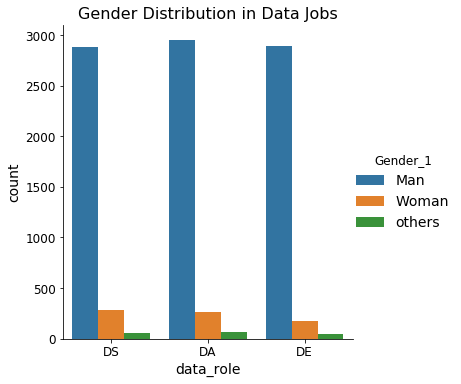

In [226]:
gender_types = ['Man', 'Woman', 'others']

g = sns.catplot(x='data_role', kind='count', hue='Gender_1', 
            data=df_data)

g.axes.flat[0].set_title("Gender Distribution in Data Jobs", fontsize=16)

Text(0.5, 1, 'Salaries in Data Jobs by Genders')

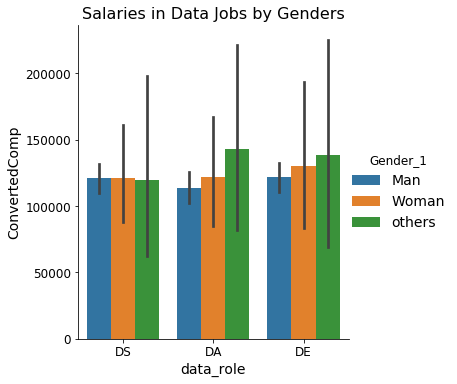

In [227]:
gender_types = ['Man', 'Woman', 'others']

g = sns.catplot(x='data_role', y='ConvertedComp', kind='bar', hue='Gender_1', 
            data=df_data)

g.axes.flat[0].set_title("Salaries in Data Jobs by Genders", fontsize=16)

Text(0.5, 1, 'Salaries in Data Jobs by Genders')

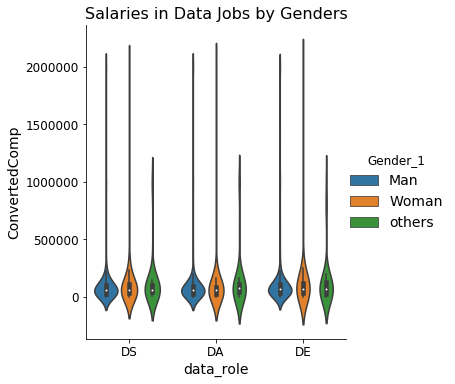

In [228]:
g = sns.catplot(x='data_role', y="ConvertedComp", kind="violin", hue='Gender_1', data=df_data)

g.axes.flat[0].set_title("Salaries in Data Jobs by Genders", fontsize=16)

#### **2.2.4. salary v.s. data role for different coding YearsCodePro**

In [154]:
df_data['YearsCodePro'] = pd.to_numeric(df_data['YearsCodePro'].str.\
                replace('Less than 1 year', '0').\
                str.replace('More than 50 years', '51'), downcast='integer')

In [158]:
df_data['YearsCodePro'].quantile(q=[0.25, 0.5, 0.75])

0.25     3.0
0.50     6.0
0.75    13.0
Name: YearsCodePro, dtype: float64

In [160]:
df_data['YearsCodePro'].min()

0.0

In [163]:
# divide "YearsCodePro" into 4 bins

df_data['YearsCodeProBin'] = pd.qcut(df_data['YearsCodePro'], 4, labels=['0-3 years', '3-6 years', '6-13 years', '13+years'])

In [166]:
df_data['YearsCodeProBin'].value_counts()

0-3 years     3302
6-13 years    2520
13+years      2459
3-6 years     2311
Name: YearsCodeProBin, dtype: int64

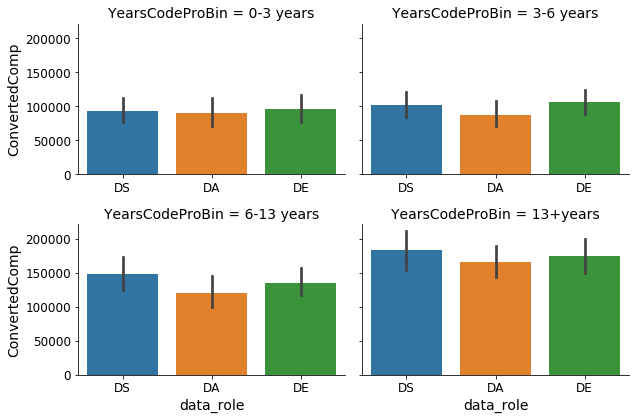

In [165]:
g = sns.FacetGrid(df_data, 
                  col='YearsCodeProBin', hue='data_role',
                  col_wrap=2, col_order=['0-3 years', '3-6 years', '6-13 years', '13+years'], aspect=1.5, sharex=False)

g.map(sns.barplot, 'data_role', "ConvertedComp", order=["DS", "DA", "DE"])

## 3. Job Satisfation (EDA)

### 3.1. **job satisfaction v.s. data role**

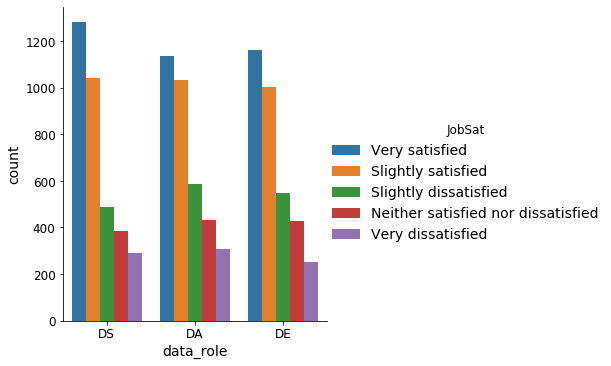

In [58]:
sns.catplot(x='data_role', kind='count', hue='JobSat', 
            data=df_data, hue_order=['Very satisfied', 'Slightly satisfied', 
                                      'Slightly dissatisfied', 
                                      'Neither satisfied nor dissatisfied', 
                                      'Very dissatisfied'])

### 3.2. **Job satisfation v.s. salary**

Text(0.5, 1, 'Salaries v.s. Job Satisfaction\n by Jobs')

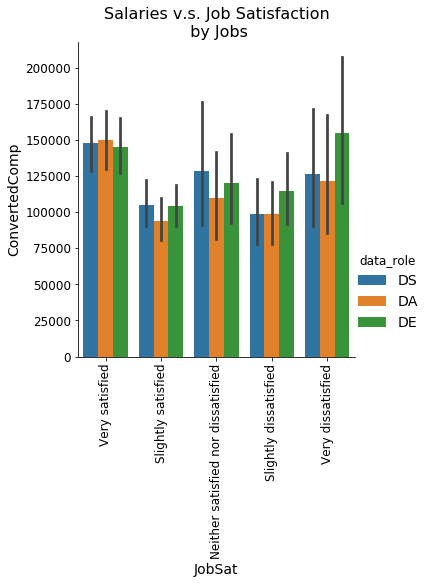

In [243]:
ax = sns.catplot(x='JobSat', y="ConvertedComp", hue='data_role',
                 kind='bar', 
                 data=df_data, 
                 order=['Very satisfied', 'Slightly satisfied',
                        'Neither satisfied nor dissatisfied',
                        'Slightly dissatisfied',
                        'Very dissatisfied'])

ax.set_xticklabels(rotation=90)

ax.axes.flat[0].set_title("Salaries v.s. Job Satisfaction\n by Jobs", fontsize=16)

Text(0.5, 1, 'Salary v.s. Job Satisfaction')

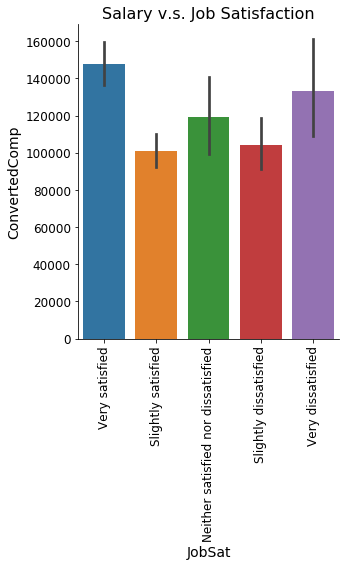

In [244]:
ax = sns.catplot(x='JobSat', y="ConvertedComp", 
                 kind='bar', 
                 data=df_data, 
                 order=['Very satisfied', 'Slightly satisfied',
                        'Neither satisfied nor dissatisfied',
                        'Slightly dissatisfied',
                        'Very dissatisfied'])

ax.set_xticklabels(rotation=90)
ax.axes.flat[0].set_title("Salary v.s. Job Satisfaction", fontsize=16)

### 3.3. **job satisfaction v.s. OrgSize**

In [60]:
_ = {'Just me - I am a freelancer, sole proprietor, etc.': 1,
               '2 to 9 employees': 2,
               '10 to 19 employees': 3,
               '20 to 99 employees': 4,
               '100 to 499 employees': 5,
               '500 to 999 employees': 6,
               '1,000 to 4,999 employees': 7,
               '5,000 to 9,999 employees': 8,
               '10,000 or more employees': 9,}

[tmp for tmp in _.keys()][-1::-1]

['10,000 or more employees',
 '5,000 to 9,999 employees',
 '1,000 to 4,999 employees',
 '500 to 999 employees',
 '100 to 499 employees',
 '20 to 99 employees',
 '10 to 19 employees',
 '2 to 9 employees',
 'Just me - I am a freelancer, sole proprietor, etc.']

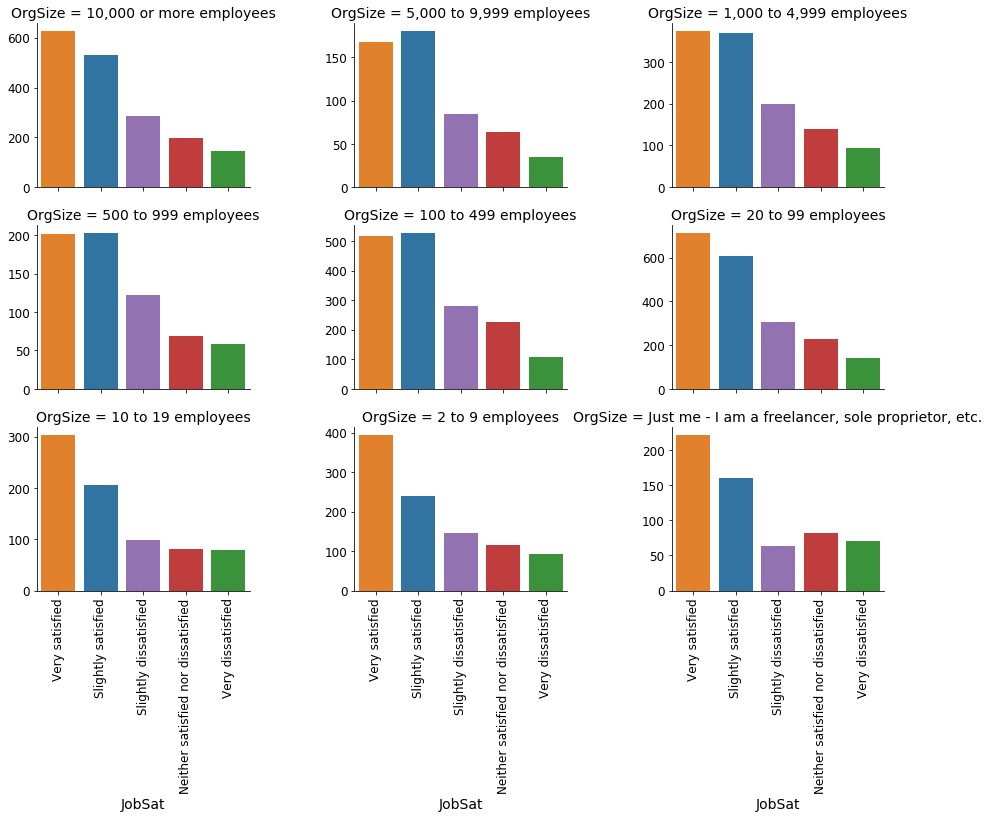

In [61]:
g = sns.FacetGrid(df_data,
                  col='OrgSize',
                  hue='JobSat',
                  col_wrap=3, 
                  col_order=['10,000 or more employees',
                             '5,000 to 9,999 employees',
                             '1,000 to 4,999 employees',
                             '500 to 999 employees',
                             '100 to 499 employees',
                             '20 to 99 employees',
                             '10 to 19 employees',
                             '2 to 9 employees',
                             'Just me - I am a freelancer, sole proprietor, etc.'],
                  sharex=True, sharey=False, aspect=1.5)

g.map(sns.countplot, 'JobSat', order=['Very satisfied', 'Slightly satisfied', 
                                      'Slightly dissatisfied', 
                                      'Neither satisfied nor dissatisfied', 
                                      'Very dissatisfied'])

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

### 3.4. **job satisfaction v.s. NEWOvertime**

In [62]:
_ = {'Never': 0,
 'Rarely: 1-2 days per year or less': 1,
                   'Occasionally: 1-2 days per quarter but less than monthly': 2,
                   'Sometimes: 1-2 days per month but less than weekly': 3,
                   'Often: 1-2 days per week or more': 4}

[tmp for tmp in _.keys()]

['Never',
 'Rarely: 1-2 days per year or less',
 'Occasionally: 1-2 days per quarter but less than monthly',
 'Sometimes: 1-2 days per month but less than weekly',
 'Often: 1-2 days per week or more']

Text(0.5, 1, 'NEWOvertime = Occasionally: 1-2 days per quarter \n but less than monthly')

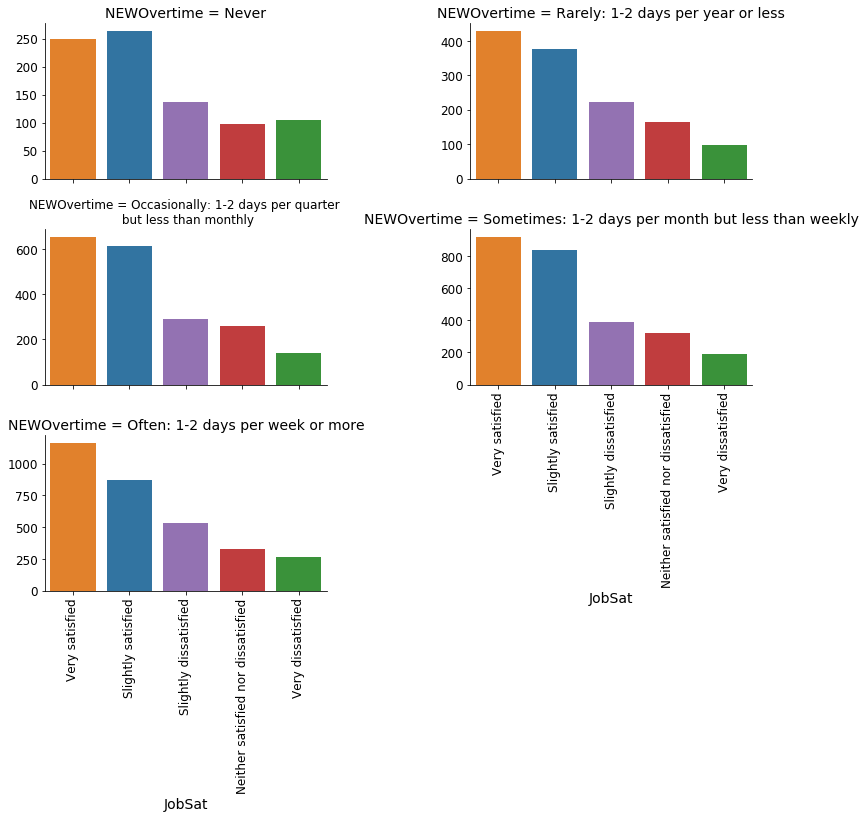

In [63]:
g = sns.FacetGrid(df_data,
                  col='NEWOvertime',
                  hue='JobSat',
                  col_wrap=2,
                  col_order=['Never',
                             'Rarely: 1-2 days per year or less',
                             'Occasionally: 1-2 days per quarter but less than monthly',
                             'Sometimes: 1-2 days per month but less than weekly',
                             'Often: 1-2 days per week or more'],
                  sharex=True, sharey=False, aspect=2)

g.map(sns.countplot, 'JobSat', order=['Very satisfied', 'Slightly satisfied', 
                                      'Slightly dissatisfied', 
                                      'Neither satisfied nor dissatisfied', 
                                      'Very dissatisfied'])

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

ax_tmp = g.axes.flat[2]
ax_tmp.set_title('NEWOvertime = Occasionally: 1-2 days per quarter \n but less than monthly')

### 3.5. **job satisfaction distribution in different countries**

In [64]:
df_data['JobSat'].value_counts().index

Index(['Very satisfied', 'Slightly satisfied', 'Slightly dissatisfied',
       'Neither satisfied nor dissatisfied', 'Very dissatisfied'],
      dtype='object')

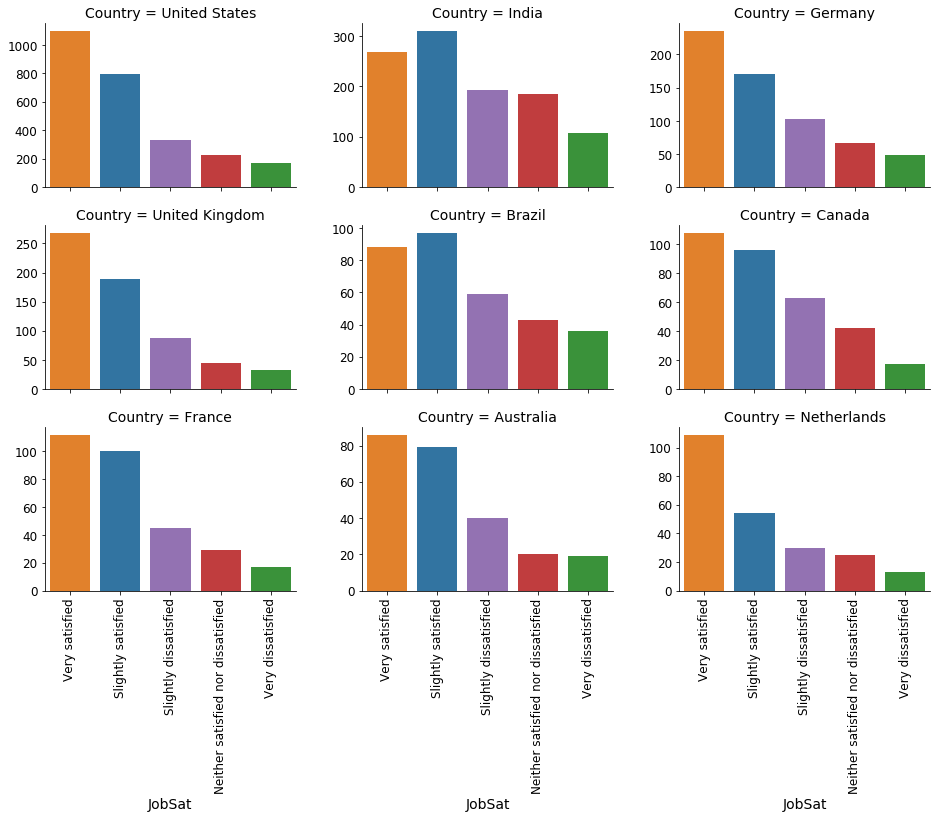

In [277]:
top_ten_countries = ['United States', 'India', 'Germany', 'United Kingdom', 'Brazil', 
                     'Canada', 'France', 'Australia', 'Netherlands']

g = sns.FacetGrid(df_data[df_data['Country'].isin(top_ten_countries)], 
                  col='Country', 
                  hue='JobSat',
                  col_wrap=3, col_order=top_ten_countries, aspect=1.5,
                  sharex=True, sharey=False)
g.map(sns.countplot, 'JobSat', order=['Very satisfied', 'Slightly satisfied', 
                                      'Slightly dissatisfied', 
                                      'Neither satisfied nor dissatisfied', 
                                      'Very dissatisfied'])

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

## 4. Change of data jobs, comparing 2020 data to 2019
* Change of the numbers of data roles;
* Change of Salary;
* Change of Job Satisfaction.

### 4.1. prepare 2019 data

In [67]:
df_survey_2019 = pd.read_csv(os.path.join(root_dir, 'data/developer_survey_2019/survey_results_public.csv'))
df_survey_2019.shape

(88883, 85)

In [119]:
data_related_cond_2019 = df_survey_2019['DevType'].str.contains('data(?![a-z])', case=False, regex=True)

print(f"Participants who are data-related roles: {data_related_cond_2019.sum()}")

Participants who are data-related roles: 13808


In [116]:
# focus on the actitely employed participants only
valid_employed = ['Employed full-time', 'Employed part-time',
                  'Independent contractor, freelancer, or self-employed']

valid_employed_cond_2019 = df_survey_2019['Employment'].isin(valid_employed)
print(f"Participants who are currently actively employed: {sum(valid_employed_cond_2019)}")

Participants who are currently actively employed: 77420


In [122]:
sum(data_related_cond_2019 & valid_employed_cond_2019)/sum(valid_employed_cond_2019)

0.16711444071299406

In [184]:
# focus on currently actively employed only
print(f"Total number of responders who are actively employed: {sum(valid_employed_cond_2019)}\n"
      f"Percentage of responders who process a data-related role: "
      f"{sum(valid_employed_cond_2019 & data_related_cond_2019) / sum(valid_employed_cond_2019)*100: 5.2f}%")

Total number of responders who are actively employed: 77420
Percentage of responders who process a data-related role:  16.71%


In [70]:
df_data_2019 = extract_data_related(df_survey_2019)

In [71]:
df_data_2019.shape

(17370, 89)

In [72]:
df_data.shape

(11186, 66)

### 4.2. Change of the number of data roles

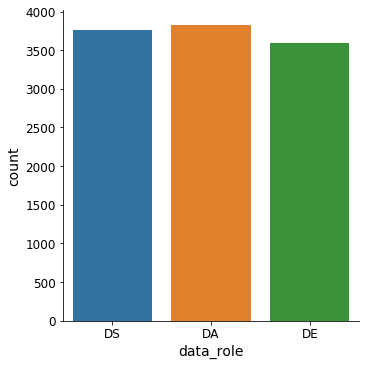

In [74]:
sns.catplot(x="data_role", kind='count', data=df_data)

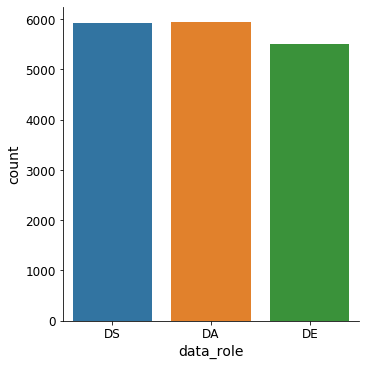

In [73]:
sns.catplot(x="data_role", kind='count', data=df_data_2019)

In [82]:
trend_role_count = df_data_2019['data_role'].value_counts().to_frame().rename(columns={'data_role': 2019}).\
join(df_data['data_role'].value_counts().to_frame().rename(columns={'data_role': 2020})).T

trend_role_count

,DA,DS,DE
2019,5952,5922,5496
2020,3832,3761,3593


Text(0.5, 1.0, 'Numbers of Data Roles v.s. Year')

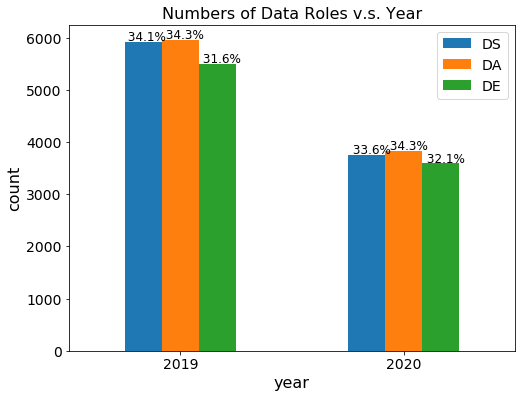

In [254]:
fig, ax = plt.subplots(figsize=(8, 6))
trend_role_count[['DS', 'DA', 'DE']].plot.bar(ax=ax, rot=0)

values = [0.340933, 0.336224,
          0.342660, 0.342571,
          0.316408, 0.321205]
for p, v in zip(ax.patches, values):
    ax.annotate(f"{v*100: 4.1f}%", (p.get_x() * 1.005, p.get_height() * 1.005))
    
ax.tick_params(labelsize=14)
ax.set_xlabel('year', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_title('Numbers of Data Roles v.s. Year', fontsize=16)

In [87]:
trend_role_percent = trend_role_count.copy()

In [90]:
trend_role_percent["total"] = trend_role_percent.sum(axis=1)

In [98]:
trend_role_percent.apply(lambda x: x/x['total'], axis=1)[['DS', 'DA', 'DE']]

,DS,DA,DE
2019,0.340933,0.342660,0.316408
2020,0.336224,0.342571,0.321205


### 4.3. Change of annual salary

In [139]:
pd.pivot_table(df_data, values='ConvertedComp', index='data_role')

,ConvertedComp
data_role,
DA,117228.031972
DE,125454.218274
DS,123911.183276


In [144]:
trend_salary = pd.pivot_table(df_data_2019, values='ConvertedComp', index='data_role').rename(columns={'ConvertedComp': '2019'}).\
 join(pd.pivot_table(df_data, values='ConvertedComp', index='data_role').rename(columns={'ConvertedComp': '2020'})).T

trend_salary

data_role,DA,DE,DS
2019,135532.920573,141837.794395,142191.269860
2020,117228.031972,125454.218274,123911.183276


Text(0.5, 1.0, 'Annual salary v.s. Year')

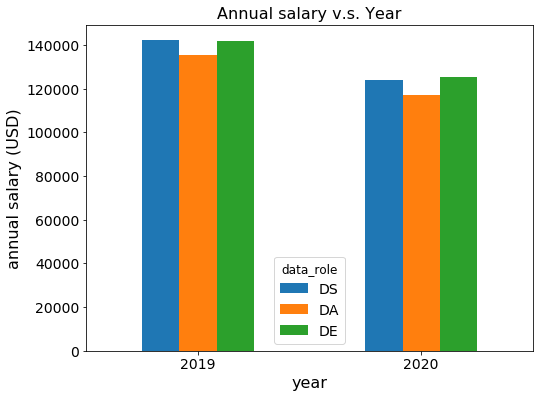

In [148]:
fig, ax = plt.subplots(figsize=(8, 6))
trend_salary[['DS', 'DA', 'DE']].plot.bar(ax=ax, rot=0)

ax.tick_params(labelsize=14)
ax.set_xlabel('year', fontsize=16)
ax.set_ylabel('annual salary (USD)', fontsize=16)
ax.set_title('Annual salary v.s. Year', fontsize=16)

In [188]:
### check US data

print(len(df_data_2019[df_data_2019['Country'] == 'United States']), len(df_data_2019))
print(len(df_data[df_data['Country'] == 'United States']), len(df_data))

4859 17370
2757 11186


In [146]:
trend_salary_US = pd.pivot_table(df_data_2019[df_data_2019['Country'] == 'United States'], values='ConvertedComp', index='data_role').rename(columns={'ConvertedComp': '2019'}).\
 join(pd.pivot_table(df_data[df_data['Country'] == 'United States'], values='ConvertedComp', index='data_role').rename(columns={'ConvertedComp': '2020'})).T

trend_salary_US

data_role,DA,DE,DS
2019,254785.127119,266385.664557,283993.970065
2020,218727.357713,238684.505525,263221.188291


Text(0.5, 1.0, 'Annual Salary in US v.s. Year')

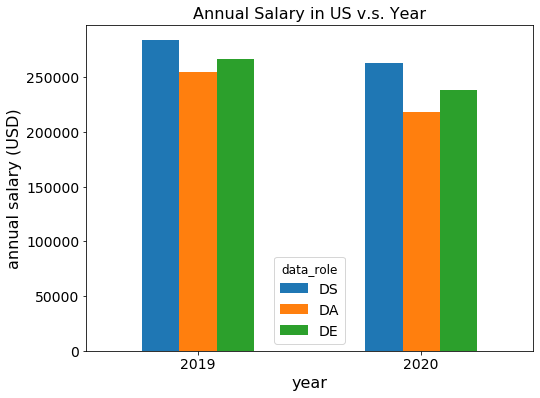

In [249]:
fig, ax = plt.subplots(figsize=(8, 6))
trend_salary_US[['DS', 'DA', 'DE']].plot.bar(ax=ax, rot=0)

ax.tick_params(labelsize=14)
ax.set_xlabel('year', fontsize=16)
ax.set_ylabel('annual salary (USD)', fontsize=16)
ax.set_title('Annual Salary in US v.s. Year', fontsize=16)

### 4.4. Change of Job Satisfaction

In [169]:
df_data_2019['JobSat'].value_counts()

Slightly satisfied                    5346
Very satisfied                        5239
Slightly dissatisfied                 2253
Neither satisfied nor dissatisfied    1908
Very dissatisfied                     1112
Name: JobSat, dtype: int64

In [173]:
df_data['JobSat'].value_counts()

Very satisfied                        3582
Slightly satisfied                    3079
Slightly dissatisfied                 1623
Neither satisfied nor dissatisfied    1242
Very dissatisfied                      846
Name: JobSat, dtype: int64

In [172]:
satisfaction_map = {'Very satisfied': 2, 
                    'Slightly satisfied': 1, 
                    'Neither satisfied nor dissatisfied': 0, 
                    'Slightly dissatisfied': -1, 
                    'Very dissatisfied': -2}

In [175]:
df_data['JobSat_Score'] = df_data['JobSat'].map(satisfaction_map)
df_data_2019['JobSat_Score'] = df_data_2019['JobSat'].map(satisfaction_map)

In [176]:
print(df_data_2019['JobSat_Score'].mean(), df_data['JobSat_Score'].mean())

0.7155378988523143 0.6679521789433089


In [177]:
trend_satisfaction = pd.pivot_table(df_data_2019, values='JobSat_Score', index='data_role').rename(columns={'JobSat_Score': '2019'}).\
 join(pd.pivot_table(df_data, values='JobSat_Score', index='data_role').rename(columns={'JobSat_Score': '2020'})).T

trend_satisfaction

data_role,DA,DE,DS
2019,0.653209,0.724442,0.769388
2020,0.602344,0.671091,0.730769


Text(0.5, 1.0, 'Satisfaction v.s. Year')

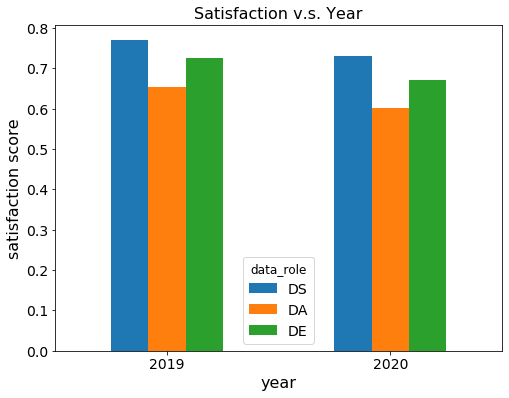

In [250]:
fig, ax = plt.subplots(figsize=(8, 6))
trend_satisfaction[['DS', 'DA', 'DE']].plot.bar(ax=ax, rot=0)

ax.tick_params(labelsize=14)
ax.set_xlabel('year', fontsize=16)
ax.set_ylabel('satisfaction score', fontsize=16)
ax.set_title('Satisfaction v.s. Year', fontsize=16)

Text(0.5, 1.0, 'Satisfaction v.s. Year')

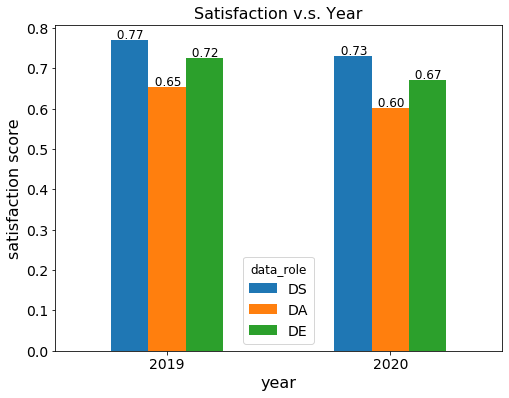

In [255]:
fig, ax = plt.subplots(figsize=(8, 6))
trend_satisfaction[['DS', 'DA', 'DE']].plot.bar(ax=ax, rot=0)

values = [0.769388, 0.730769, 
          0.653209, 0.602344, 
          0.724442, 0.671091]

for p, v in zip(ax.patches, values):
    ax.annotate(f"{v: 4.2f}", (p.get_x() * 1.0 + 0.01, p.get_height() * 1.005))
    
ax.tick_params(labelsize=14)
ax.set_xlabel('year', fontsize=16)
ax.set_ylabel('satisfaction score', fontsize=16)
ax.set_title('Satisfaction v.s. Year', fontsize=16)

## 5. Modelling (use 2020 data)

We use the Stack Oveflow 2020 Survey data, and predict the job satisfaction. There are five possible responses to the answer on job satisfaction
(**'Very satisfied', 'Slightly satisfied', 'Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Very dissatisfied'**), therefore it's a multi-classification problem. We use an untune Gaussian Navie Bayes as a baseline model and then use cross-validation to tune a XGBoost model.

**Data preparation:**

Section 5.1. will guid you through detailed steps for data preparation. And Section 5.2. will include all these steps in one. Data preparation includes:

1. remove unvalid rows. we use responses that are currently employed only;
2. remove trivial columns (not important to modelling or can introduce leakage);
3. parse features into the correct types, which includes year and age-related features;
4. feature selection based on mutual-info;
5. For some questions, the responders can choose more than one answer. We expand one column into multiple yes/no columns;
6. Missing value imputation:
    * Numeric feature: imputed by mean value. It's a simple and reasonable choice for numeric features (Age, Salary, WorkHours) in this case.
    * Categorical feature: we impute the missing value by creating a new category as "Missing".
7. Categorical feature encoding: ordinal encoding if feature values have order, otherwise using one-hot-encoding

**Modelling:**
1. Grid Search for hyperparameter tuning;
2. Model performance eveluation;
3. Model explaianability.

In [91]:
from data_process import cal_basic_info

In [92]:
df_data.shape

(11750, 66)

In [175]:
df_data.columns.tolist()

['Respondent',
 'MainBranch',
 'Hobbyist',
 'Age',
 'Age1stCode',
 'CompFreq',
 'CompTotal',
 'ConvertedComp',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'EdLevel',
 'Employment',
 'Ethnicity',
 'Gender',
 'JobFactors',
 'JobSat',
 'JobSeek',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'NEWCollabToolsDesireNextYear',
 'NEWCollabToolsWorkedWith',
 'NEWDevOps',
 'NEWDevOpsImpt',
 'NEWEdImpt',
 'NEWJobHunt',
 'NEWJobHuntResearch',
 'NEWLearn',
 'NEWOffTopic',
 'NEWOnboardGood',
 'NEWOtherComms',
 'NEWOvertime',
 'NEWPurchaseResearch',
 'NEWPurpleLink',
 'NEWSOSites',
 'NEWStuck',
 'OpSys',
 'OrgSize',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'PurchaseWhat',
 'Sexuality',
 'SOAccount',
 'SOComm',
 'SOPartFreq',
 'SOVisitFreq',
 'SurveyEase',
 'SurveyLength',
 'Trans',
 'UndergradMajor',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'WelcomeChange',
 'W

In [93]:
df_data.select_dtypes(include='number').columns

Index(['Respondent', 'Age', 'CompTotal', 'ConvertedComp', 'WorkWeekHrs'], dtype='object')

Note:

* only for currently employed responders


### 5.1. data preparation (step by step)

#### 5.1.1. remove some trivial columns by human investigation

In [146]:
df_data_info = cal_basic_info(df_data.drop(columns=['DevType_list']))

In [147]:
pd.set_option('display.max_rows', 100)

In [97]:
df_data_info

,dtypes,null counts,null percent,mean,std,min,max,nunique
Respondent,int64,0,0.000000,3.089389e+04,1.894739e+04,22.0,6.560200e+04,NaN
MainBranch,object,46,0.391489,NaN,NaN,NaN,NaN,6.0
Hobbyist,object,0,0.000000,NaN,NaN,NaN,NaN,2.0
Age,float64,2707,23.038298,3.281809e+01,9.390893e+00,1.0,9.900000e+01,NaN
Age1stCode,object,80,0.680851,NaN,NaN,NaN,NaN,52.0
CompFreq,object,2612,22.229787,NaN,NaN,NaN,NaN,4.0
CompTotal,float64,3956,33.668085,2.566076e+146,1.601795e+148,0.0,1.000000e+150,NaN
ConvertedComp,float64,3974,33.821277,1.221882e+05,2.759070e+05,0.0,2.000000e+06,NaN
Country,object,0,0.000000,NaN,NaN,NaN,NaN,149.0
CurrencyDesc,object,1357,11.548936,NaN,NaN,NaN,NaN,118.0


In [186]:
# object columns that have unique values more than 50
df_data_info[df_data_info['nunique'] > 50].index.tolist()

['Age1stCode',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'Ethnicity',
 'JobFactors',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'NEWCollabToolsDesireNextYear',
 'NEWCollabToolsWorkedWith',
 'NEWJobHunt',
 'NEWJobHuntResearch',
 'NEWPurchaseResearch',
 'NEWSOSites',
 'NEWStuck',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'YearsCode',
 'YearsCodePro']

In [148]:
df_data_info[df_data_info['nunique'] > 50]

,dtypes,null counts,null percent,mean,std,min,max,nunique
Age1stCode,object,80,0.680851,NaN,NaN,NaN,NaN,52.0
Country,object,0,0.000000,NaN,NaN,NaN,NaN,149.0
CurrencyDesc,object,1357,11.548936,NaN,NaN,NaN,NaN,118.0
CurrencySymbol,object,1357,11.548936,NaN,NaN,NaN,NaN,118.0
DatabaseDesireNextYear,object,2834,24.119149,NaN,NaN,NaN,NaN,1424.0
DatabaseWorkedWith,object,1796,15.285106,NaN,NaN,NaN,NaN,1291.0
DevType,object,0,0.000000,NaN,NaN,NaN,NaN,3889.0
Ethnicity,object,2498,21.259574,NaN,NaN,NaN,NaN,98.0
JobFactors,object,1585,13.489362,NaN,NaN,NaN,NaN,219.0
LanguageDesireNextYear,object,1294,11.012766,NaN,NaN,NaN,NaN,3965.0


In [149]:
# trivial columns for modelling

trivial_cols = ['Respondent', 'DevType_list', 
                'CompFreq', 'CompTotal', 
                'CurrencyDesc', 'CurrencySymbol', 
                'DatabaseDesireNextYear', 'DatabaseWorkedWith', 
                'DevType', 
                'Gender', 'JobFactors', 'JobSeek',
                # --
                'LanguageDesireNextYear',
                # 'LanguageWorkedWith',   # to use
                'MiscTechDesireNextYear', 
                'MiscTechWorkedWith',
                'NEWCollabToolsDesireNextYear',
                # 'NEWCollabToolsWorkedWith',  # to use
                'NEWJobHunt',  
                'NEWJobHuntResearch',
                'NEWPurchaseResearch',
                'NEWSOSites',
                'NEWStuck',
                'PlatformDesireNextYear',
                'NEWPurpleLink',
                # 'PlatformWorkedWith',  # to use
                'WebframeDesireNextYear',
                'WebframeWorkedWith', 
                ## 
                'NEWOffTopic', 'NEWOtherComms', 'Sexuality', 
                'SOAccount', 'SOComm', 
                'SurveyEase', 'SurveyLength', 
                'Trans', 'WelcomeChange', 
                'PurchaseWhat', 
                'data_related']

#### 5.1.2. Parse Year and Age data correctly

In [150]:
from data_process import parse_age_year

In [151]:
df_data = parse_age_year(df_data)

In [152]:
df_data.drop(columns=trivial_cols, inplace=True, errors='ignore')

In [153]:
df_data.shape

(11750, 30)

In [154]:
df_data_info = cal_basic_info(df_data)

df_data_info

,dtypes,null counts,null percent,mean,std,min,max,nunique
MainBranch,object,46,0.391489,NaN,NaN,NaN,NaN,6.0
Hobbyist,object,0,0.000000,NaN,NaN,NaN,NaN,2.0
Age,float64,2707,23.038298,32.818091,9.390893,1.0,99.0,NaN
Age1stCode,float64,80,0.680851,15.502999,5.999124,4.0,86.0,NaN
ConvertedComp,float64,3974,33.821277,122188.221836,275906.999945,0.0,2000000.0,NaN
Country,object,0,0.000000,NaN,NaN,NaN,NaN,149.0
EdLevel,object,203,1.727660,NaN,NaN,NaN,NaN,10.0
Employment,object,0,0.000000,NaN,NaN,NaN,NaN,4.0
Ethnicity,object,2498,21.259574,NaN,NaN,NaN,NaN,98.0
JobSat,object,1378,11.727660,NaN,NaN,NaN,NaN,6.0


#### 5.1.3. data preparation: only consider valid data

1. only currently employed;
2. not-null JobSat

In [155]:
df_data.shape

(11750, 30)

In [156]:
df_data['Employment'].value_counts()

Employed full-time                                      9236
Independent contractor, freelancer, or self-employed    1481
Not employed, but looking for work                       564
Employed part-time                                       469
Name: Employment, dtype: int64

In [157]:
valid_employed = ['Employed full-time', 'Employed part-time', 
                  'Independent contractor, freelancer, or self-employed']
valid_employed_cond = df_data['Employment'].isin(valid_employed)

valid_jobsat = ~df_data['JobSat'].isnull()

In [158]:
df_data = df_data[valid_employed_cond & valid_jobsat]

In [159]:
df_data.shape

(10372, 30)

#### 5.1.4. data preparation: select features based on mutual information

In [160]:
moreThanOne_reponse = ['Ethnicity', 'LanguageWorkedWith', 'NEWCollabToolsWorkedWith', 'PlatformWorkedWith']

In [161]:
df_data.shape

(10372, 30)

In [162]:
# use sample data for feature selection to avoid leakage
# stratified sample
random_seed =  123

df_sample = df_data.groupby('JobSat', group_keys=False).apply(
    lambda x: x.sample(frac=0.3, replace=False, random_state=random_seed))

In [163]:
df_sample['JobSat'].value_counts()/len(df_sample)

Very satisfied                        0.345326
Slightly satisfied                    0.296820
Slightly dissatisfied                 0.156441
Neither satisfied nor dissatisfied    0.119820
Very dissatisfied                     0.081593
Name: JobSat, dtype: float64

In [118]:
df_sample.select_dtypes(include='number').columns.tolist()

['Age',
 'Age1stCode',
 'ConvertedComp',
 'WorkWeekHrs',
 'YearsCode',
 'YearsCodePro']

In [123]:
df_data.dtypes.loc[~df_data.dtypes.index.isin(['JobSat'])]

MainBranch                   object
Hobbyist                     object
Age                         float64
Age1stCode                  float64
ConvertedComp               float64
Country                      object
EdLevel                      object
Employment                   object
Ethnicity                    object
LanguageWorkedWith           object
NEWCollabToolsWorkedWith     object
NEWDevOps                    object
NEWDevOpsImpt                object
NEWEdImpt                    object
NEWLearn                     object
NEWOnboardGood               object
NEWOvertime                  object
NEWPurpleLink                object
OpSys                        object
OrgSize                      object
PlatformWorkedWith           object
SOPartFreq                   object
SOVisitFreq                  object
UndergradMajor               object
WorkWeekHrs                 float64
YearsCode                   float64
YearsCodePro                float64
multiple_roles              

In [124]:
from data_process import cal_mutual_info

In [168]:
df_f_mutual_info = cal_mutual_info(df_sample.drop(columns=moreThanOne_reponse), target_var='JobSat', disc_features_only=False)

In [173]:
df_f_mutual_info = df_f_mutual_info.sort_values('mutual_info', ascending=False)

df_f_mutual_info[df_f_mutual_info['mutual_info'] > 0.005]

,columns,mutual_info
5,Country,0.112716
12,NEWOnboardGood,0.029186
18,UndergradMajor,0.014982
2,Age,0.014183
19,WorkWeekHrs,0.013520
20,YearsCode,0.013402
10,NEWEdImpt,0.012986
4,ConvertedComp,0.012985
6,EdLevel,0.012450
15,OrgSize,0.011074


In [174]:
df_f_mutual_info[df_f_mutual_info['mutual_info'] > 0.005].shape

(14, 2)

In [178]:
f_from_mutual_info = df_f_mutual_info[df_f_mutual_info['mutual_info'] > 0.005]['columns'].values.tolist()
print(f_from_mutual_info)

['Country', 'NEWOnboardGood', 'UndergradMajor', 'Age', 'WorkWeekHrs', 'YearsCode', 'NEWEdImpt', 'ConvertedComp', 'EdLevel', 'OrgSize', 'Age1stCode', 'SOPartFreq', 'NEWOvertime', 'YearsCodePro']


#### 5.1.5. data preparation: apply MultiLabelBinarizer to list columns

In the columns of interest, there are several fields that reponnders can select more than one choice. 

['Ethnicity', 'LanguageWorkedWith', 'NEWCollabToolsWorkedWith', 'PlatformWorkedWith']

* We can expand the column into mutiple columns with yes/no response (similar to one-hot-encoder);
* To simplify the process and reduce the amount of one-hot-encoded features, we only use feature 'LanguageWorkedWith'.

In [179]:
from data_process import StringtoListTranformer, ListColumnsEncoder

In [181]:
multiple_response = ['LanguageWorkedWith']
str_to_list = StringtoListTranformer(variables=multiple_response)
df_tmp = str_to_list.fit_transform(df_data[multiple_response])

list_encoder = ListColumnsEncoder(variables=multiple_response)
df_tmp = list_encoder.fit_transform(df_tmp)

In [184]:
df_tmp

,Assembly,Bash/Shell/PowerShell,C,C#,C++,Dart,Go,HTML/CSS,Haskell,Java,...,Perl,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA
35,0,0,0,1,0,0,1,1,0,1,...,0,1,1,0,0,1,0,0,0,0
46,0,1,0,1,0,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,0
68,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
76,0,0,0,0,1,0,0,1,0,1,...,0,1,1,0,0,0,0,0,0,0
123,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64053,0,1,1,0,1,0,1,1,0,1,...,0,1,0,0,1,0,0,0,1,0
64057,0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
64113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64121,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [190]:
f_from_mutual_info

['Country',
 'NEWOnboardGood',
 'UndergradMajor',
 'Age',
 'WorkWeekHrs',
 'YearsCode',
 'NEWEdImpt',
 'ConvertedComp',
 'EdLevel',
 'OrgSize',
 'Age1stCode',
 'SOPartFreq',
 'NEWOvertime',
 'YearsCodePro']

In [194]:
df_data = pd.concat([df_data[f_from_mutual_info], df_tmp], axis=1).reset_index(drop=True)

### 5.2. data preparation (all in one step)

In [8]:
random_seed =  123

In [9]:
from data_process import extract_data_related, parse_age_year, StringtoListTranformer, ListColumnsEncoder

# data preparation, all steps

df_survey = pd.read_csv(os.path.join(root_dir, 'data/developer_survey_2020/survey_results_public.csv'))

# only data-related jobs
df_survey['data_related'] = df_survey['DevType'].\
    str.contains('data(?![a-z])', case=False, regex=True)

df_data = df_survey[df_survey['data_related']==True].copy()

# expand multiple devType into multiple instances
df_data = extract_data_related(df_survey)

# convert genders into three types
df_data['Gender_1'] = df_data['Gender'].apply(
    lambda x: x if pd.isna(x) or x == 'Man' or x == 'Woman' else 'others')

# parse age/year features
df_data = parse_age_year(df_data)


# remove trivial columns
trivial_cols = ['Respondent', 'DevType_list', 
                'CompFreq', 'CompTotal', 
                'CurrencyDesc', 'CurrencySymbol', 
                'DatabaseDesireNextYear', 'DatabaseWorkedWith', 
                'DevType', 
                'Gender', 'JobFactors', 'JobSeek',
                # --
                'LanguageDesireNextYear',
                # 'LanguageWorkedWith',   # to use
                'MiscTechDesireNextYear', 
                'MiscTechWorkedWith',
                'NEWCollabToolsDesireNextYear',
                # 'NEWCollabToolsWorkedWith',  # to use
                'NEWJobHunt',  
                'NEWJobHuntResearch',
                'NEWPurchaseResearch',
                'NEWSOSites',
                'NEWStuck',
                'PlatformDesireNextYear',
                'NEWPurpleLink',
                # 'PlatformWorkedWith',  # to use
                'WebframeDesireNextYear',
                'WebframeWorkedWith', 
                ## 
                'NEWOffTopic', 'NEWOtherComms', 'Sexuality', 
                'SOAccount', 'SOComm', 
                'SurveyEase', 'SurveyLength', 
                'Trans', 'WelcomeChange', 
                'PurchaseWhat', 
                'data_related'
               ]

df_data.drop(columns=trivial_cols, inplace=True, errors='ignore')

# keep only employed instances and not-null JobSat
valid_employed = ['Employed full-time', 'Employed part-time',
                  'Independent contractor, freelancer, or self-employed']
valid_employed_cond = df_data['Employment'].isin(valid_employed)

valid_jobsat = ~df_data['JobSat'].isnull()

df_data = df_data[valid_employed_cond & valid_jobsat]

# expand columns that have more than one choice into multiple yes/no columns
multiple_response = ['LanguageWorkedWith']
str_to_list = StringtoListTranformer(variables=multiple_response)
df_tmp = str_to_list.fit_transform(df_data[multiple_response])
list_encoder = ListColumnsEncoder(variables=multiple_response)
df_tmp = list_encoder.fit_transform(df_tmp)

# keep the selected features from mutual info selection and the expanded columns of interest
# remove country for easy processing
f_from_mutual_info = ['NEWOnboardGood', 'UndergradMajor', 
                      'Age', 'WorkWeekHrs', 'YearsCode', 'NEWEdImpt', 
                      'ConvertedComp', 'EdLevel', 'OrgSize', 'Age1stCode', 
                      'SOPartFreq', 'NEWOvertime', 'YearsCodePro']

df_data = pd.concat([df_data[f_from_mutual_info + ['JobSat']], df_tmp], axis=1).reset_index(drop=True)
# df_data = df_data[f_from_mutual_info + ['JobSat']].copy()

In [10]:
print(f"{df_tmp.shape[1]} new columns from expanding column ''LanguageWorkedWith''")

25 new columns from expanding column ''LanguageWorkedWith''


In [11]:
df_data.shape

(10372, 39)

In [282]:
df_data.head(5)

,NEWOnboardGood,UndergradMajor,Age,WorkWeekHrs,YearsCode,NEWEdImpt,ConvertedComp,EdLevel,OrgSize,Age1stCode,...,Perl,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA
0,Yes,"Computer science, computer engineering, or sof...",34.0,40.0,4.0,Somewhat important,77556.0,Some college/university study without earning ...,"1,000 to 4,999 employees",30.0,...,0,1,1,0,0,1,0,0,0,0
1,Onboarding? What onboarding?,"A natural science (such as biology, chemistry,...",53.0,40.0,43.0,Not at all important/not necessary,74970.0,"Other doctoral degree (Ph.D., Ed.D., etc.)",10 to 19 employees,10.0,...,0,1,0,1,0,1,0,0,0,0
2,No,"Computer science, computer engineering, or sof...",25.0,40.0,13.0,Very important,594539.0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20 to 99 employees,12.0,...,0,1,0,0,0,0,0,0,0,0
3,Yes,"Computer science, computer engineering, or sof...",NaN,60.0,30.0,Critically important,NaN,"Other doctoral degree (Ph.D., Ed.D., etc.)",100 to 499 employees,6.0,...,0,1,1,0,0,0,0,0,0,0
4,Yes,NaN,41.0,40.0,11.0,Critically important,2000000.0,"Other doctoral degree (Ph.D., Ed.D., etc.)","5,000 to 9,999 employees",30.0,...,0,1,0,0,0,1,0,0,0,0


In [283]:
df_data['JobSat'].value_counts()[['Very satisfied', 'Slightly satisfied', 
                                  'Neither satisfied nor dissatisfied', 
                                  'Slightly dissatisfied', 'Very dissatisfied']]/len(df_data['JobSat'])

Very satisfied                        0.345353
Slightly satisfied                    0.296857
Neither satisfied nor dissatisfied    0.119745
Slightly dissatisfied                 0.156479
Very dissatisfied                     0.081566
Name: JobSat, dtype: float64

### 5.3. training/valid/test split

In [12]:
from sklearn.model_selection import train_test_split

target_var = 'JobSat'

X = df_data.drop(columns=['JobSat'])

y = df_data[['JobSat']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

In [13]:
print(X_train.shape)
print(X_test.shape)

(8297, 38)
(2075, 38)


In [14]:
from modelling import train_valid_stratify_split

In [15]:
valid_fold = train_valid_stratify_split(X_train, y_train)

In [16]:
from sklearn.model_selection import PredefinedSplit

In [17]:
ps = PredefinedSplit(valid_fold)

In [18]:
for train_index, valid_index in ps.split():
    print("TRAIN:", len(train_index), "Valid:", len(valid_index))

TRAIN: 6637 Valid: 1660


In [19]:
ps.get_n_splits()

1

### 5.4. Baseline model: Gaussian Naive Bayes

In [39]:
from modelling import gnb_clf_pipe

In [48]:
from modelling import get_performance

In [40]:
gnb_clf_pipe.fit(X_train, y_train['JobSat'].values)

Pipeline(steps=[('numeric_imputer',
                 NumericalImputer(variables=['Age', 'Age1stCode',
                                             'ConvertedComp', 'WorkWeekHrs',
                                             'YearsCode', 'YearsCodePro'])),
                ('categorical_imputer',
                 CategoricalImputer(variables=['NEWOnboardGood',
                                               'UndergradMajor', 'NEWEdImpt',
                                               'EdLevel', 'OrgSize',
                                               'SOPartFreq', 'NEWOvertime'])),
                ('categorical_orderEncoder',
                 OrdinalEncoder(cols=['NEWEdImpt...
                                                      'Multiple times per day': 6}},
                                         {'col': 'NEWOvertime',
                                          'mapping': {'Missing': -1, 'Never': 0,
                                                      'Occasionally: 1-2 days per quar

In [41]:
gnb_clf_pipe.classes_

array(['Neither satisfied nor dissatisfied', 'Slightly dissatisfied',
       'Slightly satisfied', 'Very dissatisfied', 'Very satisfied'],
      dtype='<U34')

In [59]:

roc_auc_score_perf_train, logLoss_perf_train, \
accuracy_perf_train, precision_score_perf_train, recall_score_perf_train, \
conf_m_train = get_performance(gnb_clf_pipe, X_train, y_train['JobSat'].values)

train_performance = pd.Series([roc_auc_score_perf_train, logLoss_perf_train, \
                               accuracy_perf_train, 
                               precision_score_perf_train, recall_score_perf_train], index=['roc-auc_macro', 'logloss', 'accuracy', 'precison_macro', 'recall_macro'])


roc_auc_score_perf_test, logLoss_perf_test, \
accuracy_perf_test, precision_score_perf_test, recall_score_perf_test, \
conf_m_test = get_performance(gnb_clf_pipe, X_test, y_test['JobSat'].values)

test_performance = pd.Series([roc_auc_score_perf_test, logLoss_perf_test, \
                               accuracy_perf_test, 
                               precision_score_perf_test, recall_score_perf_test], index=['roc-auc_macro', 'logloss', 'accuracy', 'precison_macro', 'recall_macro'])



performance_check = pd.DataFrame.from_dict({'train': train_performance, 'test': test_performance})
performance_check

/Users/lcx/anaconda3/envs/ML_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lcx/anaconda3/envs/ML_py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,train,test
roc-auc_macro,0.536886,0.524705
logloss,1.639067,1.773135
accuracy,0.324575,0.319518
precison_macro,0.170933,0.138208
recall_macro,0.212485,0.209772


Text(0.5, 1, 'Confusion matrix (train)')

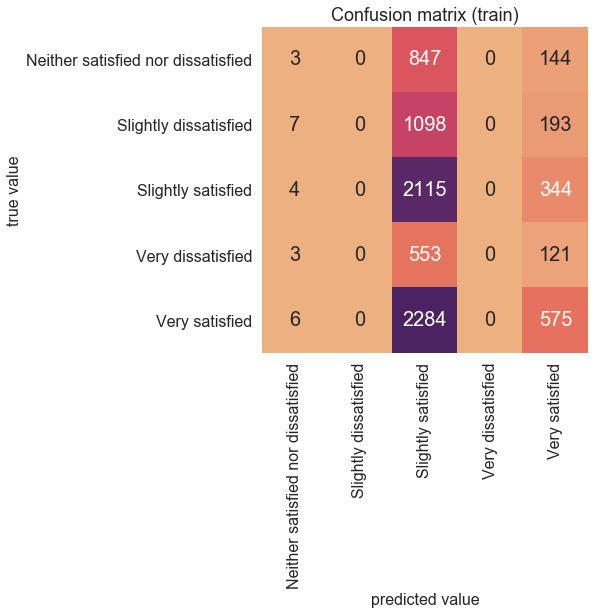

In [46]:
fig, ax = plt.subplots(figsize=(6,6))

sns.set(font_scale=3)
# cmap = sns.diverging_palette(220 , 10, as_cmap=True)
# sns.color_palette("rocket", as_cmap=True)

sns.set(font_scale=1)
x_axis_labels = ['Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Slightly satisfied', 'Very dissatisfied', 'Very satisfied']
y_axis_labels = ['Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Slightly satisfied', 'Very dissatisfied', 'Very satisfied']
cmap = sns.color_palette("flare", as_cmap=True)
sns.heatmap(conf_m_train, square=True, annot=True, cbar=False, cmap=cmap,
            annot_kws={'fontsize': 20}, fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('predicted value', fontsize=16)
ax.set_ylabel('true value', fontsize=16)
ax.set_title('Confusion matrix (train)', fontsize=18)

Text(0.5, 1, 'Confusion matrix (test)')

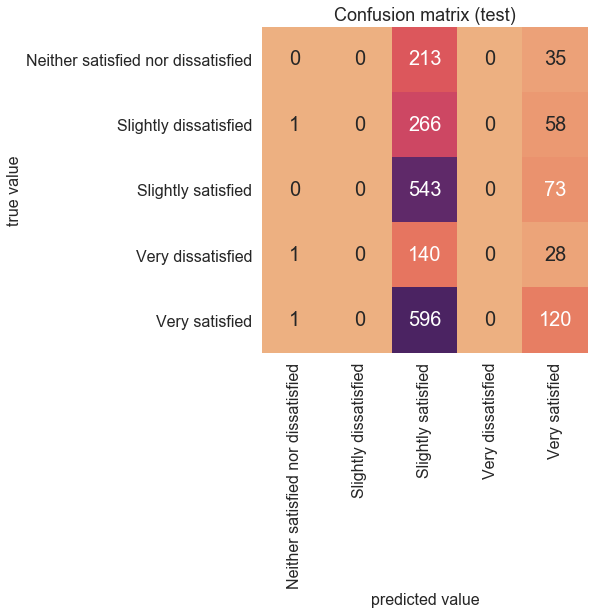

In [60]:
fig, ax = plt.subplots(figsize=(6,6))

# cmap = sns.diverging_palette(220 , 10, as_cmap=True)
# sns.color_palette("rocket", as_cmap=True)

sns.set(font_scale=1)
x_axis_labels = ['Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Slightly satisfied', 'Very dissatisfied', 'Very satisfied']
y_axis_labels = ['Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Slightly satisfied', 'Very dissatisfied', 'Very satisfied']
cmap = sns.color_palette("flare", as_cmap=True)
sns.heatmap(conf_m_test, square=True, annot=True, cbar=False, cmap=cmap,
            annot_kws={'fontsize': 20}, fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('predicted value', fontsize=16)
ax.set_ylabel('true value', fontsize=16)
ax.set_title('Confusion matrix (test)', fontsize=18)

### 5.5. XGBoost for multt-class classification

#### 5.5.1. Hyperparamete tuning

In [292]:
from modelling import clf_pipe

from sklearn.model_selection import GridSearchCV

In [293]:
param_grid = {
    'xgb__learning_rate': [0.1],
    'xgb__min_child_weight': [10],
    'xgb__subsample': [0.8],
    'xgb__gamma': [1, 5],
    'xgb__n_estimators': [200, 300, 400],
    'xgb__max_depth': [4, 6],
    'xgb__colsample_bytree': [0.6, 0.8]
}

clf_cv = GridSearchCV(clf_pipe, 
                      param_grid=param_grid,
                      cv=ps,
                      scoring=['roc_auc_ovr', 'neg_log_loss', 'accuracy', 'precision_macro', 'recall_macro'],
                      return_train_score=True,
                      refit='roc_auc_ovr')

In [294]:
clf_cv.fit(X_train, y_train['JobSat'].values)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('numeric_imputer',
                                        NumericalImputer(variables=['Age',
                                                                    'Age1stCode',
                                                                    'ConvertedComp',
                                                                    'WorkWeekHrs',
                                                                    'YearsCode',
                                                                    'YearsCodePro'])),
                                       ('categorical_imputer',
                                        CategoricalImputer(variables=['NEWOnboardGood',
                                                                      'UndergradMajor',
                                                                      'NEWEdImpt',
                                                     

In [37]:
df_cv_result = pd.DataFrame(clf_cv.cv_results_)

In [38]:
df_cv_result[['param_xgb__n_estimators', 'param_xgb__gamma',
              'param_xgb__max_depth', 'param_xgb__colsample_bytree', 
              'mean_train_roc_auc_ovr', 'mean_test_roc_auc_ovr', 
              'mean_train_neg_log_loss', 'mean_test_neg_log_loss',
              'mean_train_accuracy', 'mean_test_accuracy',
              'mean_train_precision_macro', 'mean_test_precision_macro',
              'mean_train_recall_macro', 'mean_test_recall_macro']].sort_values('mean_test_roc_auc_ovr', ascending=False).head(5)

,param_xgb__n_estimators,param_xgb__gamma,param_xgb__max_depth,param_xgb__colsample_bytree,mean_train_roc_auc_ovr,mean_test_roc_auc_ovr,mean_train_neg_log_loss,mean_test_neg_log_loss,mean_train_accuracy,mean_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro
17,400,1,6,0.8,0.989845,0.736464,-0.596855,-1.252128,0.897695,0.522892,0.928275,0.524580,0.859204,0.430635
16,300,1,6,0.8,0.981814,0.730588,-0.685163,-1.260243,0.852042,0.521084,0.898210,0.537597,0.798016,0.427006
5,400,1,6,0.6,0.986125,0.727448,-0.646274,-1.265173,0.870423,0.520482,0.908169,0.537511,0.821640,0.431621
4,300,1,6,0.6,0.976155,0.721515,-0.734761,-1.276549,0.826277,0.509036,0.879911,0.533612,0.762387,0.413484
15,200,1,6,0.8,0.962137,0.718204,-0.819867,-1.283806,0.780322,0.493373,0.853438,0.505804,0.701752,0.386159


In [173]:
clf_cv.best_params_

{'xgb__colsample_bytree': 0.8,
 'xgb__gamma': 1,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 6,
 'xgb__min_child_weight': 10,
 'xgb__n_estimators': 400,
 'xgb__subsample': 0.8}

#### Hyperparameter visualization

Text(0.5, 1.0, 'Performance v.s. Number of trees')

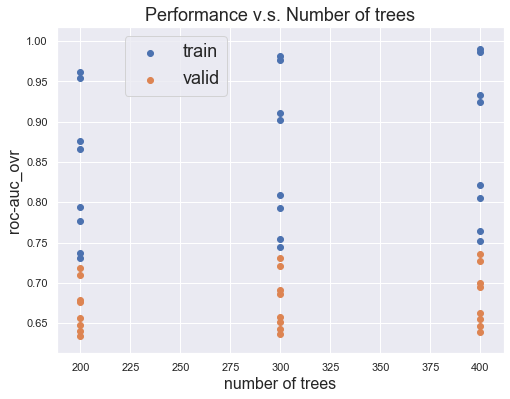

In [74]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_cv_result['param_xgb__n_estimators'], df_cv_result['mean_train_roc_auc_ovr'], label='train')
ax.scatter(df_cv_result['param_xgb__n_estimators'], df_cv_result['mean_test_roc_auc_ovr'], label='valid')
ax.legend(fontsize=18, loc='best', bbox_to_anchor=(0.2, 0.8, 0.2, 0.2))

ax.set_xlabel('number of trees', fontsize=16)
ax.set_ylabel('roc-auc_ovr', fontsize=16)
ax.set_title('Performance v.s. Number of trees', fontsize=18)

In [65]:
hyperTune_result = df_cv_result[['param_xgb__n_estimators', 'param_xgb__gamma',
                                 'param_xgb__max_depth', 'param_xgb__colsample_bytree',
                                 'mean_test_roc_auc_ovr']].rename(columns={'param_xgb__n_estimators': 'n_estimator', 
                                                                           'param_xgb__gamma': 'gamma',
                                                                           'param_xgb__max_depth': 'max_depth', 
                                                                           'param_xgb__colsample_bytree': 'colsample_bytree',
                                                                           'mean_test_roc_auc_ovr': 'roc_auc_ovr'}).to_dict('records')

In [75]:
import hiplot as hip

hip.Experiment.from_iterable(hyperTune_result).display()

<IPython.core.display.Javascript object>

#### 5.5.2. Model performance evaluation

In [63]:
roc_auc_score_perf_train, logLoss_perf_train, \
accuracy_perf_train, precision_score_perf_train, recall_score_perf_train, \
conf_m_train = get_performance(clf_cv, X_train, y_train['JobSat'].values)

train_performance = pd.Series([roc_auc_score_perf_train, logLoss_perf_train, \
                               accuracy_perf_train, 
                               precision_score_perf_train, recall_score_perf_train], index=['roc-auc_macro', 'logloss', 'accuracy', 'precison_macro', 'recall_macro'])

train_performance

roc-auc_macro     0.986841
logloss           0.626144
accuracy          0.879233
precison_macro    0.916170
recall_macro      0.836253
dtype: float64

In [62]:
roc_auc_score_perf_test, logLoss_perf_test, \
accuracy_perf_test, precision_score_perf_test, recall_score_perf_test, \
conf_m_test = get_performance(clf_cv, X_test, y_test['JobSat'].values)

test_performance = pd.Series([roc_auc_score_perf_test, logLoss_perf_test, \
                               accuracy_perf_test, 
                               precision_score_perf_test, recall_score_perf_test], index=['roc-auc_macro', 'logloss', 'accuracy', 'precison_macro', 'recall_macro'])

test_performance

roc-auc_macro     0.761635
logloss           1.211040
accuracy          0.542169
precison_macro    0.577229
recall_macro      0.462148
dtype: float64

In [52]:
performance_check = pd.DataFrame.from_dict({'train': train_performance, 'test': test_performance})
performance_check

,train,test
roc-auc_macro,0.986841,0.761635
logloss,0.626144,1.211040
accuracy,0.879233,0.542169
precison_macro,0.916170,0.577229
recall_macro,0.836253,0.462148


In [53]:
conf_m_train

array([[ 777,   18,   90,    1,  108],
       [   9, 1029,  118,    1,  141],
       [  12,   14, 2287,    2,  148],
       [  11,    8,   65,  497,   96],
       [   9,   20,  130,    1, 2705]])

Text(0.5, 1, 'Confusion matrix (train)')

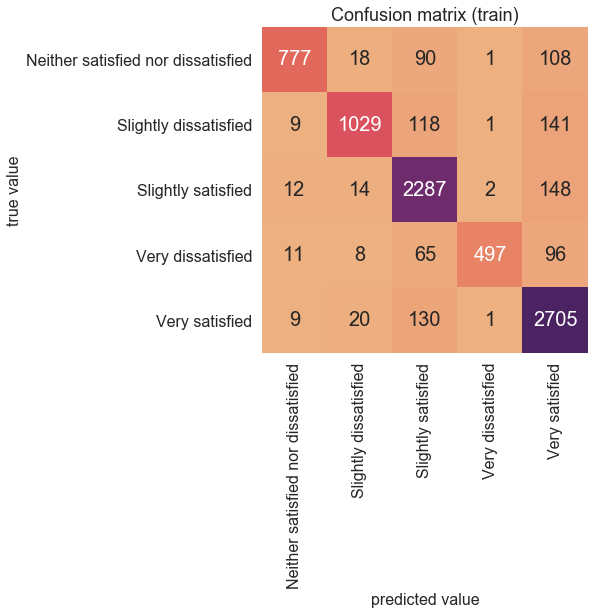

In [54]:
fig, ax = plt.subplots(figsize=(6,6))

sns.set(font_scale=3)
# cmap = sns.diverging_palette(220 , 10, as_cmap=True)
# sns.color_palette("rocket", as_cmap=True)

sns.set(font_scale=1)
x_axis_labels = ['Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Slightly satisfied', 'Very dissatisfied', 'Very satisfied']
y_axis_labels = ['Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Slightly satisfied', 'Very dissatisfied', 'Very satisfied']
cmap = sns.color_palette("flare", as_cmap=True)
sns.heatmap(conf_m_train, square=True, annot=True, cbar=False, cmap=cmap,
            annot_kws={'fontsize': 20}, fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('predicted value', fontsize=16)
ax.set_ylabel('true value', fontsize=16)
ax.set_title('Confusion matrix (train)', fontsize=18)

In [55]:
conf_m_test

array([[ 88,  19,  68,   5,  68],
       [ 16, 129,  96,   4,  80],
       [ 20,  43, 350,   9, 194],
       [  7,  12,  40,  47,  63],
       [ 12,  22, 165,   7, 511]])

Text(0.5, 1, 'Confusion matrix (test)')

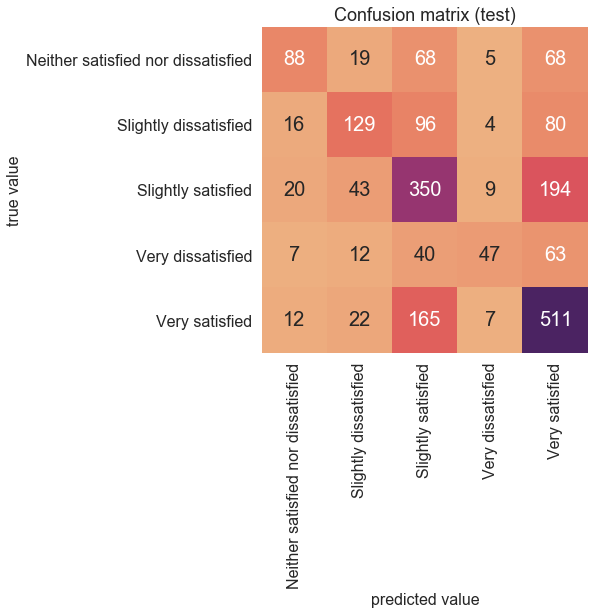

In [64]:
fig, ax = plt.subplots(figsize=(6,6))

# cmap = sns.diverging_palette(220 , 10, as_cmap=True)
# sns.color_palette("rocket", as_cmap=True)

sns.set(font_scale=1)
x_axis_labels = ['Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Slightly satisfied', 'Very dissatisfied', 'Very satisfied']
y_axis_labels = ['Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Slightly satisfied', 'Very dissatisfied', 'Very satisfied']
cmap = sns.color_palette("flare", as_cmap=True)
sns.heatmap(conf_m_test, square=True, annot=True, cbar=False, cmap=cmap,
            annot_kws={'fontsize': 20}, fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('predicted value', fontsize=16)
ax.set_ylabel('true value', fontsize=16)
ax.set_title('Confusion matrix (test)', fontsize=18)

#### 5.5.3. Save pipeline to disk

In [76]:
root_dir

'/Users/lcx/Documents/courses/udacity_DS/2-Intro_to_DS/project_medium_post'

In [298]:
import joblib

joblib.dump(clf_cv, filename=os.path.join(root_dir, 'model/xgb_cv_pipeline'))

['/Users/lcx/Documents/courses/udacity_DS/2-Intro_to_DS/project_medium_post/model/xgb_cv_pipeline']

In [21]:
# load saved pipeline
import joblib
clf_cv = joblib.load(os.path.join(root_dir, 'model/xgb_cv_pipeline'))

#### 5.5.4. Insight from modelling result

In [300]:
import xgboost

In [83]:
# print out the category_mapping for reference
clf_cv.best_estimator_['categorical_orderEncoder'].category_mapping

[{'col': 'NEWEdImpt',
  'mapping': {'Not at all important/not necessary': 0,
   'Somewhat important': 1,
   'Fairly important': 2,
   'Very important': 3,
   'Critically important': 4,
   'Missing': -1}},
 {'col': 'EdLevel',
  'mapping': {'I never completed any formal education': 0,
   'Primary/elementary school': 1,
   'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2,
   'Some college/university study without earning a degree': 3,
   'Associate degree (A.A., A.S., etc.)': 4,
   'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5,
   'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 6,
   'Professional degree (JD, MD, etc.)': 7,
   'Other doctoral degree (Ph.D., Ed.D., etc.)': 8,
   'Missing': -1}},
 {'col': 'OrgSize',
  'mapping': {'Just me - I am a freelancer, sole proprietor, etc.': 1,
   '2 to 9 employees': 2,
   '10 to 19 employees': 3,
   '20 to 99 employees': 4,
   '100 to 499 employees': 5,
   '500 to 999 employees': 6,
   '1,000 to 4,999 e

In [82]:
# print out the category_mapping for reference
clf_cv.best_estimator_['categorical_OHEncoder'].category_mapping

[{'col': 'NEWOnboardGood',
  'mapping': Yes                             1
  No                              2
  Missing                         3
  Onboarding? What onboarding?    4
  NaN                            -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'UndergradMajor',
  'mapping': Computer science, computer engineering, or software engineering                    1
  Mathematics or statistics                                                          2
  Another engineering discipline (such as civil, electrical, mechanical, etc.)       3
  Information systems, information technology, or system administration              4
  Missing                                                                            5
  A natural science (such as biology, chemistry, physics, etc.)                      6
  I never declared a major                                                           7
  A humanities discipline (such as literature, history, philosophy, etc.)            8
  A 

In [24]:
# get the xgb_model
xgb_model = clf_cv.best_estimator_['xgb']

#### Global importance from tree-bulding process

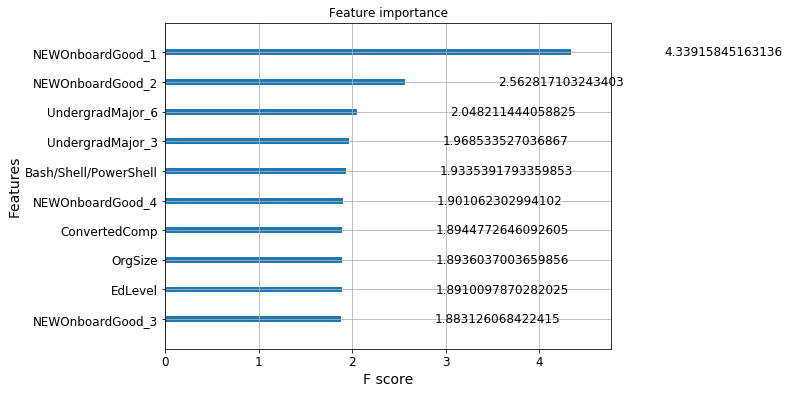

In [305]:
fig, ax = plt.subplots(figsize=(8, 6))

xgboost.plot_importance(xgb_model, importance_type='gain', max_num_features=10, ax=ax)

#### Shap value for feature importance

In [22]:
# need to process X before we can feed it to the xgb model
X_test_for_xgb = clf_cv.best_estimator_[:-1].transform(X_test)

In [23]:
X_test_for_xgb.shape

(2075, 53)

In [25]:
# use shap which is a versatile package for explainability
import shap

# compute SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_for_xgb)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


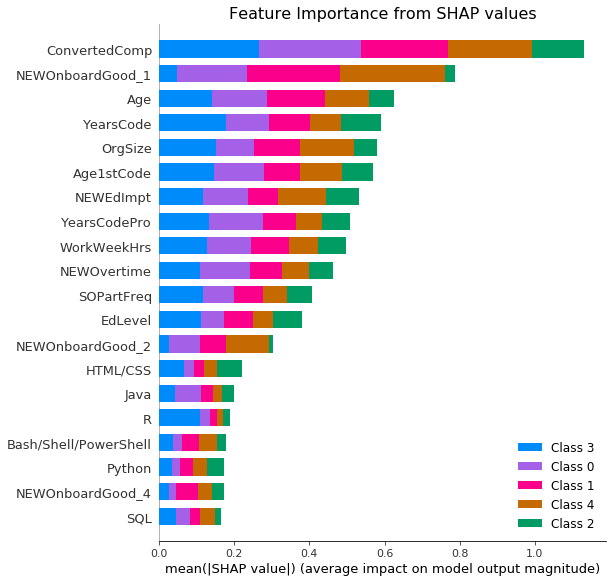

In [31]:
# global feature importance from SHAP values
plt.title("Feature Importance from SHAP values", fontsize=16)

shap.summary_plot(shap_values, X_test_for_xgb, plot_type="bar")


#### SHAP Value for dependence plot

Here we focus on predicting "Very satisfied"

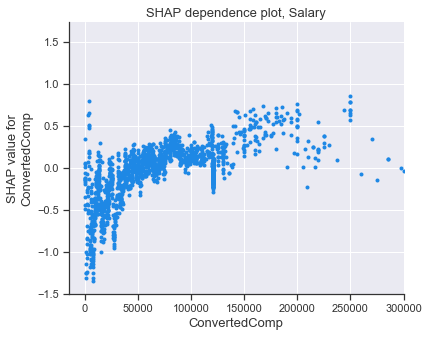

In [314]:
shap.dependence_plot("ConvertedComp", shap_values[4], X_test_for_xgb, interaction_index=None, xmin=0, xmax=300000, title='SHAP dependence plot, Salary')

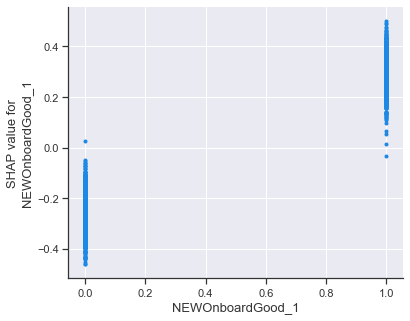

In [108]:
shap.dependence_plot("NEWOnboardGood_1", shap_values[4], X_test_for_xgb, interaction_index=None)

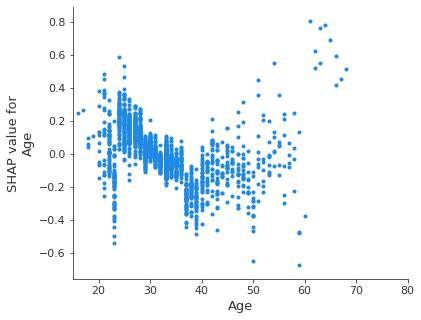

In [33]:
shap.dependence_plot("Age", shap_values[4], X_test_for_xgb, interaction_index=None, xmin=15, xmax=80)

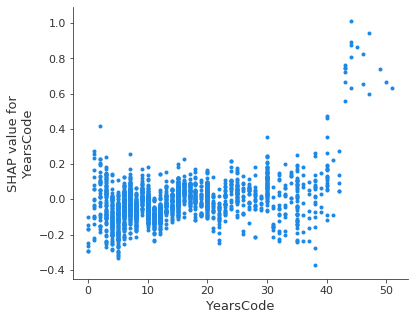

In [36]:
shap.dependence_plot("YearsCode", shap_values[4], X_test_for_xgb, interaction_index=None)

In [113]:
OrgSiz_decode = {'Just me - I am a freelancer, sole proprietor, etc.': 1,
   '2 to 9 employees': 2,
   '10 to 19 employees': 3,
   '20 to 99 employees': 4,
   '100 to 499 employees': 5,
   '500 to 999 employees': 6,
   '1,000 to 4,999 employees': 7,
   '5,000 to 9,999 employees': 8,
   '10,000 or more employees': 9,
   'Missing': -1}

OrgSiz_decode = {v: k for k, v in OrgSiz_decode.items()}

OrgSiz_decode

{1: 'Just me - I am a freelancer, sole proprietor, etc.',
 2: '2 to 9 employees',
 3: '10 to 19 employees',
 4: '20 to 99 employees',
 5: '100 to 499 employees',
 6: '500 to 999 employees',
 7: '1,000 to 4,999 employees',
 8: '5,000 to 9,999 employees',
 9: '10,000 or more employees',
 -1: 'Missing'}

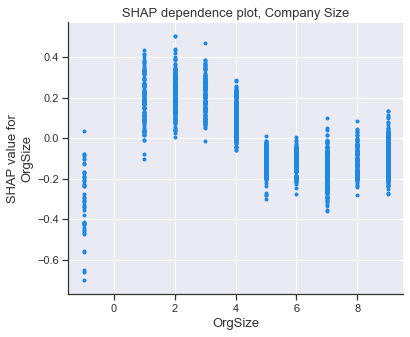

In [315]:
shap.dependence_plot("OrgSize", shap_values[4], X_test_for_xgb, interaction_index=None, title='SHAP dependence plot, Company Size')

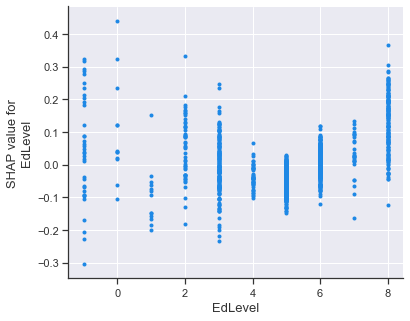

In [121]:
shap.dependence_plot("EdLevel", shap_values[4], X_test_for_xgb, interaction_index=None)

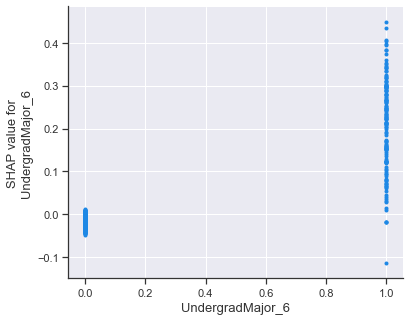

In [100]:
# A natural science (such as biology, chemistry, physics, etc.)   

shap.dependence_plot("UndergradMajor_6", shap_values[4], X_test_for_xgb, interaction_index=None)

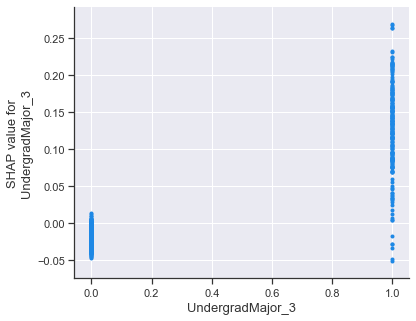

In [313]:
# sns.set_theme()

# Another engineering discipline (such as civil, electrical, mechanical, etc.)
shap.dependence_plot("UndergradMajor_3", shap_values[4], X_test_for_xgb, interaction_index=None, )

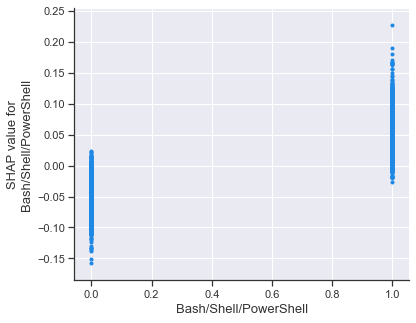

In [104]:
shap.dependence_plot("Bash/Shell/PowerShell", shap_values[4], X_test_for_xgb, interaction_index=None)